# Promo Lift Stock Demand % --- POC Regression Model for Predicting Promo Lift as Percentage Lift of Stock Demand
* Load necessary packages to execute model forecasting
* Query data as tab delimited output files to folder location


#### Last Updated = 8/12/24

In [1]:
import numpy as np
import pandas as pd
from pandasql import sqldf
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from  datetime import datetime, timedelta
from mlforecast import MLForecast
from mlforecast.target_transforms import BaseTargetTransform
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
from window_ops.ewm import ewm_mean
import os, sys, gc, time, warnings, pickle, psutil, random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#import shap
#from mlforecast.callbacks import SaveFeatures # testing callback
#from mlforecast.utils import PredictionIntervals

# Define function to display dataframe summary information
def display_df(df, message = ""):
    print("\n\n ----- dataframe name is {} -----".format(message))
    num_rows = len(df)
    num_cols = len(df.columns)
    print("\n\n num_rows = {:,} \n num_cols = {:,}\n".format(num_rows, num_cols))
    display(df.head())
    print(df.info())

# For nixtla plotting
def plot(df, fname, last_n=24 * 7):
    fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(40, 30), gridspec_kw=dict(hspace=0.5))
    uids = df['unique_id'].unique()
    for i, (uid, axi) in enumerate(zip(uids, ax.flat)):
        legend = i % 2 == 0
        df[df['unique_id'].eq(uid)].tail(last_n).set_index('ds').plot(ax=axi, title=uid, legend=legend)
    fig.savefig(fname, bbox_inches='tight')
    plt.close()
    
# For feature importance computation and charting    
def get_feat_imp(fcst=None, top=None, bottom=None):
    """
    Get the feature importance
    Args:
        model_name: model name
        top: return top n by gain
        bottom: return bottom m by gain
    Returns:
        feat_imp: feature importance by gain
    """
    # Get feature importance
    model = fcst.models_['y']
    gain = model.feature_importances_
    feat_imp = pd.DataFrame({
        "feature": model.feature_name_,
        "gain": 100 * gain / gain.sum()
    })
    feat_imp = feat_imp.sort_values("gain", ascending=False)
    feat_imp = feat_imp.reset_index(drop=True)

    # Remove the middle features by gain
    top = len(feat_imp) if top is None else top
    bottom = 0 if bottom is None else bottom
    assert top + bottom <= len(feat_imp), \
        "top + bottom exceeds feature length"
    feat_imp = feat_imp[
        (feat_imp.index < top) |
        (feat_imp.index >= len(feat_imp) - bottom - 1)
    ]
    # feat_imp = feat_imp.set_index('feature')
    return feat_imp

# For introducing custom local scaler for minmax (localstandardscaler is not found in mlforecast.target_transforms
class LocalMinMaxScaler(BaseTargetTransform):
    """Scales each serie to be in the [0, 1] interval."""
    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        self.stats_ = df.groupby(self.id_col)[self.target_col].agg(['min', 'max'])
        df = df.merge(self.stats_, on=self.id_col)
        df[self.target_col] = (df[self.target_col] - df['min']) / (df['max'] - df['min'])
        df = df.drop(columns=['min', 'max'])
        return df

    def inverse_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.merge(self.stats_, on=self.id_col)
        for col in df.columns.drop([self.id_col, self.time_col, 'min', 'max']):
            df[col] = df[col] * (df['max'] - df['min']) + df['min']
        df = df.drop(columns=['min', 'max'])
        return df
    
# ignore warnings given nulls expected in certain fields for lag features to make more readable    
# not a best practice to use so will leave commented out given testing and development to occur but if needing for presentation can add this before run
warnings.filterwarnings('ignore') 


In [2]:
#####################################  Memory Reducer ##################################### 
# :df pandas dataframe to reduce size             # type: pd.DataFrame()
# :verbose                                        # type: bool
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2F} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                       df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### Define file path for data files *****

In [3]:
filepath = 'C:\\Users\\nlarm\\OneDrive - Ace Hardware CORP\\Documents\\Python Data Files\\'

### Read data - HISTORY

##### SQL: Below is the SQL query, double-click into markdown cell to see formated code (if wanting to copy-paste into sql assistant)

SELECT 
trim(acestock_num) || '-' || trim(sapsite_cd) as unique_id,
acestock_num,
sapsite_cd as rsc,
corpweekstart_date,
type1histqty,
type2promoliftqty,
type2promoliftpct
FROM
(SELECT 
acestock_num,
sapsite_cd,
corpweekstart_date,
type1histqty,
type2promoliftqty,
type2promoliftpct,
sum(case when type2promoliftpct > 0 AND corpweekstart_date < '2024-01-01' THEN 1 else 0 end) over (partition by acestock_num, sapsite_cd) as promoliftdfu_flag
FROM
(SELECT	
T1.acestock_num, 
T1.sapsite_cd, 
to_date(start_dt) as corpweekstart_date, 
cast(sum(case when historytype_cd = '1' THEN historytype_qty else 0 end) as decimal(20,4)) as type1histqty,
cast(sum(case when historyevent_cd = 'PL' THEN historytype_qty else 0 end) as decimal(20,4)) as type2promoliftqty,
cast(sum(case when historyevent_cd = 'PL' THEN historytype_qty else 0 end) / sum(case when historytype_cd = '1' THEN historytype_qty else 0 end) as decimal(20,4)) as type2promoliftpct
FROM	WEBFOCUSVIEWS.staged_demand_history T1
INNER JOIN WEBFOCUSVIEWS.ace_date T2 on T1.start_dt = T2.ace_date 
INNER JOIN WEBFOCUSVIEWS.sap_material_site T3 on T1.acestock_num = T3.sapmaterial_num AND T1.sapsite_cd = T3.sapsite_cd
WHERE T3.sapmerchclass_cd = '877'
and T2.fiscalyear_id between year(to_date(now())) - 3 and year(to_date(now()))
group by 1,2,3
having sum(case when historytype_cd = '1' THEN historytype_qty else 0 end) > 0 ) A ) B
WHERE promoliftdfu_flag >= 6
order by 1,2,3

In [4]:
filename = 'POC_PROMOLIFT_HIST'
df_hist = pd.read_csv( filepath + filename + ".txt",delimiter="\t")

df_hist['corpweekstart_date'] = pd.to_datetime(df_hist['corpweekstart_date']) 
df_hist = df_hist.rename(columns={"corpweekstart_date": "ds"})
reduce_mem_usage(df_hist)

#convert object types to categorical
icols = ['unique_id',
         'acestock_num',
         'rsc'
        ]
for col in icols:
    df_hist[col] = df_hist[col].astype('category')
df_hist =df_hist.sort_values(by=['unique_id','ds'])
df_hist = df_hist.reset_index(drop=True)

print("\n" + '********* HISTORY columns *********')
display_df(df_hist, "df_hist")


Memory usage of dataframe is 6.81 MB
Mem. usage decreased to  4.13 Mb (39.3% reduction)

********* HISTORY columns *********


 ----- dataframe name is df_hist -----


 num_rows = 127,447 
 num_cols = 7



,unique_id,acestock_num,rsc,ds,type1histqty,type2promoliftqty,type2promoliftpct
0,8003584-AL01,8003584,AL01,2021-01-03,24.0,0.0,0.0
1,8003584-AL01,8003584,AL01,2021-01-17,12.0,0.0,0.0
2,8003584-AL01,8003584,AL01,2021-01-24,24.0,0.0,0.0
3,8003584-AL01,8003584,AL01,2021-01-31,36.0,0.0,0.0
4,8003584-AL01,8003584,AL01,2021-02-07,72.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127447 entries, 0 to 127446
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   unique_id          127447 non-null  category      
 1   acestock_num       127447 non-null  category      
 2   rsc                127447 non-null  category      
 3   ds                 127447 non-null  datetime64[ns]
 4   type1histqty       127447 non-null  float16       
 5   type2promoliftqty  127447 non-null  float16       
 6   type2promoliftpct  127447 non-null  float16       
dtypes: category(3), datetime64[ns](1), float16(3)
memory usage: 2.2 MB
None


#### Plotting an Example SKU/RSC - Visualize the Use Case

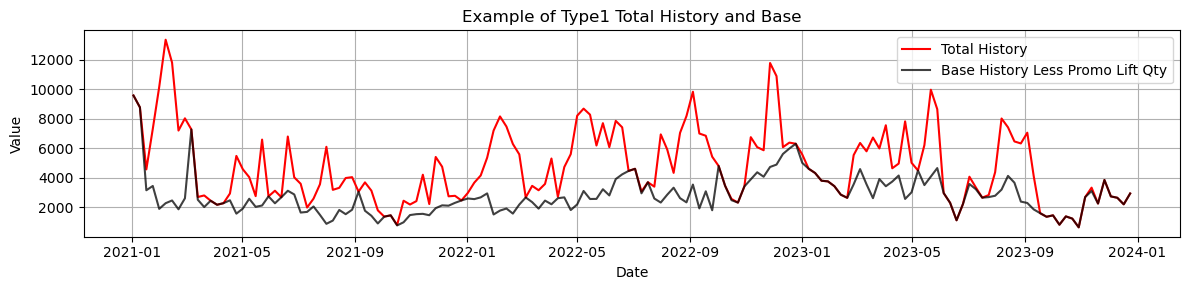

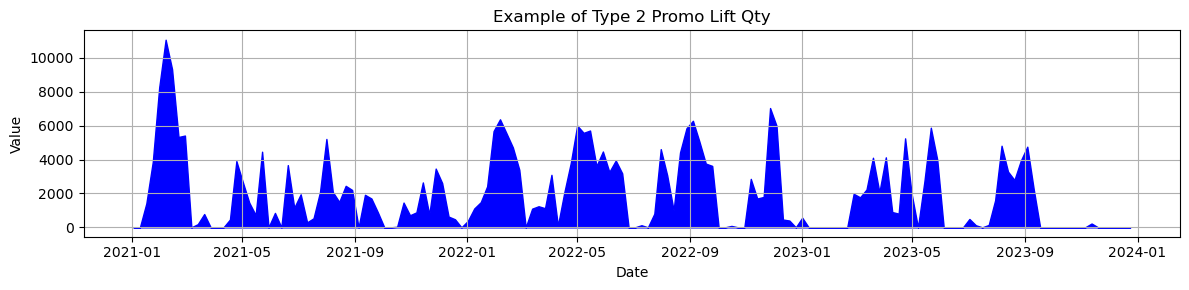

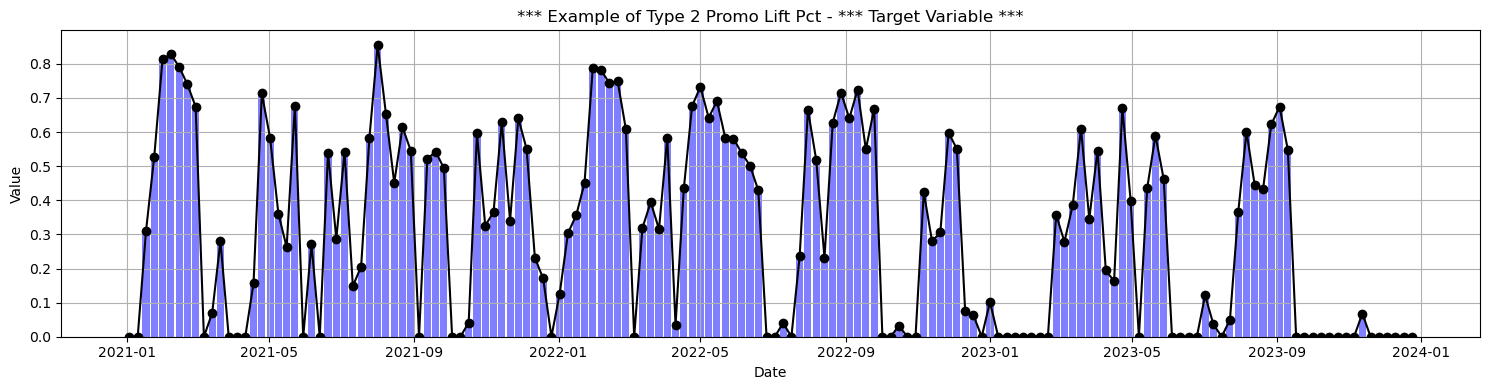

In [5]:
vizdf = df_hist[df_hist['unique_id'] == '81995-NY01']
vizdf = vizdf[vizdf['ds'] < '2023-12-31']

vizdf =vizdf.sort_values(by=['unique_id','ds'])
vizdf['type1lesstype2'] = vizdf['type1histqty'] - vizdf['type2promoliftqty']

# Plot line chart
plt.figure(figsize=(12, 3))
plt.plot(vizdf['ds'], vizdf['type1histqty'], marker=None, color='red', label='Total History')
plt.plot(vizdf['ds'], vizdf['type1lesstype2'], marker=None, color='black', alpha=0.75, label='Base History Less Promo Lift Qty')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Example of Type1 Total History and Base')
# Add gridlines
plt.grid(True)
plt.legend()
# Show plot
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.fill_between(vizdf['ds'], vizdf['type2promoliftqty'], color='blue') #, label='Promo Lift Pct')
# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Example of Type 2 Promo Lift Qty')
# Add gridlines
plt.grid(True)
#plt.legend()
# Show plot
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 4))
plt.bar(vizdf['ds'], vizdf['type2promoliftpct'], color='blue', width=6, alpha=0.5) #, label='Promo Lift Pct')
plt.plot(vizdf['ds'], vizdf['type2promoliftpct'], color='black', marker='o') #, label='Promo Lift Pct')
# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('*** Example of Type 2 Promo Lift Pct - *** Target Variable ***')
# Add gridlines
plt.grid(True)
#plt.legend()
# Show plot
plt.tight_layout()
plt.show()


del vizdf # drop visualization df

### Read data - MASTER DATA

##### SQL: Below is the SQL query, double-click into markdown cell to see formated code (if wanting to copy-paste into sql assistant)

SELECT
trim(ms.sapmaterial_num) || '-' || trim(ms.sapsite_cd) as unique_id,
ms.sapmaterial_num as acestock_num,
ms.sapsite_cd as rsc,
coalesce(ms.material_desc,'na') AS description,
CAST(ms.ITEMCOST_AMT AS DECIMAL(12,3)) AS itemcost_amt,
CAST(ms.retailerpermanentprice_amt AS DECIMAL(12,2)) AS retailerpermanentprice_amt,
CAST(ms.retailerprice_amt AS DECIMAL(12,2)) AS retailerprice_amt,
CAST(ms.aceretail_amt AS DECIMAL(12,2)) AS aceretail_amt,
CAST(ms.WEIGHTPEREACHES_QTY AS DECIMAL(12,4)) AS wgt_ea,
CAST(ms.CASEPACK_QTY AS DECIMAL(12,0)) AS cspk,
CAST(ms.IPU_QTY AS DECIMAL(12,0)) AS ipu,
CAST(ms.CUBICFEETPEREACH_AMT AS DECIMAL(12,4)) AS cuft_ea,
coalesce(ms.sapmerchclass_cd, '0') as mc,
coalesce(replace(ms.mdseclassprodgroup_cd,'_',''),'0') as mcpg,
coalesce(pim.taxonomyconcat_cd,'000000000000') as taxonomyconcat_cd,
coalesce(dscv_flag,0) as dscv_flag,
coalesce(ms.sapbuyer_cd,'00!') as sapbuyer_cd,
coalesce(ms.dept_num,'0') as dept_num,
coalesce(ms.sapvendor_num,'0') as sapvendor_num,
coalesce(TRIM(UPPER(REGEXP_REPLACE(ms.consumerbrand_nm, '[^a-zA-Z0-9]+', ''))),'NONE') AS consumerbrand_nm,
coalesce(TRIM(ms.velocityunit_cd),'N') AS velocityunit_cd
from sap_material_site ms
inner join sap_site sit ON ms.sapsite_cd = sit.SAPSITE_CD
--left outer join sap_material_unit mu ON ms.INNERPACKEACHES_CD = mu.UNITUOM_CD AND ms.SAPMATERIAL_NUM = mu.SAPMATERIAL_NUM
left outer join sap_vendor v on ms.sapvendor_num = v.sapvendor_num
left outer join pim_product pim on ms.sapmaterial_num = pim.sapmaterial_num
left outer join (select distinct acestock_num, 1 as dscv_flag
from discovery_acestock where discoveryformat_cd IN ('U','N','S','C') ) dscv on ms.sapmaterial_num = dscv.acestock_num
WHERE  ms.SAPMERCHCLASS_CD = '877' AND
sit.sitetype_Desc IN ('RSC','RDC')
AND ms.TYPE_CD = 'HAWA'
AND ms.SAPVENDOR_NUM<>'99999'
AND ms.NONSTOCK_FL IS NULL
AND ms.MULTIPLEMATERIAL_FL NOT IN ('LUMF')
ORDER BY 1

In [6]:
filename = 'POC_PROMOLIFT_MD'
df_md = pd.read_csv( filepath + filename + ".txt",delimiter="\t")
reduce_mem_usage(df_md)
#convert object types to categorical
icols = ['unique_id',
         'acestock_num',
         'rsc',
         'description',
         'sapbuyer_cd',
         'consumerbrand_nm',
         'velocityunit_cd',
         'sapvendor_num'
        ]
for col in icols:
    df_md[col] = df_md[col].astype('category')
    
print("\n" + '********* MASTER DATA columns *********')
display_df(df_md, "df_md")

Memory usage of dataframe is 3.32 MB
Mem. usage decreased to  1.72 Mb (48.2% reduction)

********* MASTER DATA columns *********


 ----- dataframe name is df_md -----


 num_rows = 20,742 
 num_cols = 21



,unique_id,acestock_num,rsc,description,itemcost_amt,retailerpermanentprice_amt,retailerprice_amt,aceretail_amt,wgt_ea,cspk,...,cuft_ea,mc,mcpg,taxonomyconcat_cd,dscv_flag,sapbuyer_cd,dept_num,sapvendor_num,consumerbrand_nm,velocityunit_cd
0,8000262-AL01,8000262,AL01,REDBARN BIRDFEEDER 1.5LB,11.5,13.617188,13.617188,26.984375,1.599609,1,...,2.101562,877,87702,12010301002,0,09H,9,52591,HOMEBAZAAR,D
1,8000262-AR01,8000262,AR01,REDBARN BIRDFEEDER 1.5LB,11.5,13.617188,13.617188,26.984375,1.599609,1,...,2.101562,877,87702,12010301002,0,09H,9,52591,HOMEBAZAAR,D
2,8000262-AZ01,8000262,AZ01,REDBARN BIRDFEEDER 1.5LB,11.5,13.617188,13.617188,26.984375,1.599609,1,...,2.101562,877,87702,12010301002,0,09H,9,52591,HOMEBAZAAR,D
3,8000262-CA01,8000262,CA01,REDBARN BIRDFEEDER 1.5LB,11.5,13.617188,13.617188,26.984375,1.599609,1,...,2.101562,877,87702,12010301002,0,09H,9,52591,HOMEBAZAAR,X
4,8000262-CO01,8000262,CO01,REDBARN BIRDFEEDER 1.5LB,11.5,13.617188,13.617188,26.984375,1.599609,1,...,2.101562,877,87702,12010301002,0,09H,9,52591,HOMEBAZAAR,D


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20742 entries, 0 to 20741
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   unique_id                   20742 non-null  category
 1   acestock_num                20742 non-null  category
 2   rsc                         20742 non-null  category
 3   description                 20742 non-null  category
 4   itemcost_amt                19551 non-null  float16 
 5   retailerpermanentprice_amt  20669 non-null  float16 
 6   retailerprice_amt           20742 non-null  float16 
 7   aceretail_amt               20742 non-null  float16 
 8   wgt_ea                      20742 non-null  float16 
 9   cspk                        20742 non-null  int16   
 10  ipu                         20742 non-null  int8    
 11  cuft_ea                     20742 non-null  float16 
 12  mc                          20742 non-null  int16   
 13  mcpg            

### Read data - EVENT SKU ATTRIBUTES

##### SQL: Below is the SQL query, double-click into markdown cell to see formated code (if wanting to copy-paste into sql assistant)

SELECT DISTINCT 
event_id,
acestock_num,
event_start_dt_weekstarting,
reqdlvry1_dt_weekstarting,
event_end_dt_weekending,
ItemTypeCode,
promospcbulproccost_amt,
promospcrtlbulcost_amt,
sublistfeat_cd,
eventtype_tx,
regexp_replace(regexp_replace(regexp_replace(regexp_replace(regexp_replace(regexp_replace(regexp_replace(
regexp_replace(regexp_replace(regexp_replace(regexp_replace(regexp_replace(regexp_replace(
UPPER(EVENTDESC_TX), '[^a-zA-Z]+', ''), 'JANUARY', ''), 'FEBRUARY', ''), 'MARCH', ''), 'APRIL', ''), 'MAY', ''), 'JUNE', '')
, 'JULY', ''), 'AUGUST', ''), 'SEPTEMBER', ''), 'OCTOBER', ''), 'NOVEMBER', ''), 'DECEMBER', '') as eventdesc_tx,
promoretailprice_amt,
rebate_tx,
regionid_tx,
eventcat_cd,
ad_cd,
media_cd,
promodiscovery_fl,
retailerex_cd,
coalesce(TRIM(eplite_downloadonly_flag),'N') as eplite_downloadonly_flag,
coalesce(eplite_offertype_code,0) as eplite_offertype_code ,
coalesce(TRIM(eplite_itemtypecode),'NA') as eplite_itemtypecode
FROM
(SELECT
evs.Event_ID AS event_id,
TRIM(evs.SAPMaterial_Num) AS acestock_num,
TO_DATE(d4.CORPWEEKSTART_DATE) AS event_start_dt_weekstarting,
TO_DATE(evs.EventEnd_Dt) AS event_end_dt,
TO_DATE(d2.CORPWEEKSTART_DATE) AS reqdlvry1_dt_weekstarting,
TO_DATE(d3.CORPWEEKEND_DATE) AS event_end_dt_weekending,
CASE WHEN TRIM(evs.ItemType_Tx) LIKE '%EVENT%' OR TRIM(evs.ItemType_Tx) LIKE '%RED HOT BUY%' THEN '1'
WHEN TRIM(evs.ItemType_Tx) LIKE '%INSTANT SAVINGS%' THEN '2'
WHEN UPPER(TRIM(evs.EVENTDESC_TX)) LIKE '%MONTH LONG%' THEN '1'
WHEN UPPER(TRIM(evs.EVENTDESC_TX)) LIKE '%RHB%' THEN '1'
WHEN TRIM(evs.ItemType_Tx) = '' THEN '3'
ELSE '4' --catchall
END AS ItemTypeCode,
evs.PromoSpcBulProcCost_Amt as promospcbulproccost_amt,
evs.PromoSpcRtlBulCost_Amt as promospcrtlbulcost_amt,
TRIM(evs.SublistFeat_Cd) AS sublistfeat_cd,
TRIM(evs.EventType_Tx) AS eventtype_tx,
TRIM(evs.EventDesc_Tx) AS eventdesc_tx,
TRIM(evs.ItemType_Tx) AS itemtype_tx,
evs.PromoRetailPrice_Amt AS promoretailprice_amt,
TRIM(evs.Rebate_Tx) AS rebate_tx,
TRIM(r.RegionId_Tx) AS regionid_tx,
TRIM(evs.EventCat_Cd) AS eventcat_cd,
TRIM(evs.Ad_Cd) AS ad_cd,
TRIM(evs.Media_Cd) as media_cd,
CASE WHEN evs.Discovery_Fl ='Y' THEN 1 ELSE 0 END AS promodiscovery_fl,
CASE WHEN evs.RetailerEx_Cd IS NULL THEN 0 ELSE 1 END AS retailerex_cd,
datediff(evs.EventEnd_Dt, evs.Event_Start_Dt) as ad_length,
datediff(evs.EventEnd_Dt, evs.ReqDlvry1_Dt) as promo_length,
Rank( ) Over (PARTITION BY evs.sapmaterial_Num, evs.Event_Id ORDER BY evs.EventLine_Num ASC) AS ROW_RANKING_NUM,
COALESCE(TRIM(CASE WHEN TRIM(pel.download_only_fl) = '' THEN 'N' ELSE pel.download_only_fl END),'N') AS eplite_downloadonly_flag,
coalesce(pel.offer_type_cd,0) as eplite_offertype_code,
REGEXP_REPLACE(UPPER(TRIM(CASE WHEN item_type_cd IN (' ','') THEN 'NA' WHEN item_type_cd IS NULL THEN 'NA'
WHEN LENGTH(TRIM(item_type_cd)) = 0 THEN 'NA' 
ELSE item_type_cd END)), '[^a-zA-Z]+', '') AS eplite_itemtypecode
FROM WEBFOCUSVIEWS.SAP_EVENTPLN_LINE_SITESPECIFIC evs
INNER JOIN WEBFOCUSVIEWS.SAP_Material_Site ms ON evs.SAPMaterial_Num = ms.SAPMaterial_Num and evs.SAPSite_Cd = ms.SAPSite_Cd 
INNER JOIN WEBFOCUSVIEWS.ACE_DATE d ON d.ACE_Date = evs.Event_Start_Dt
INNER JOIN WEBFOCUSVIEWS.ACE_DATE d2 ON d2.ACE_DATE = evs.ReqDlvry1_Dt
INNER JOIN WEBFOCUSVIEWS.ACE_DATE d3 ON d3.ACE_DATE = evs.EVENTEND_DT
INNER JOIN WEBFOCUSVIEWS.ACE_DATE d4 ON d4.ACE_DATE = evs.EVENT_START_DT
LEFT OUTER JOIN WEBFOCUSVIEWS.SAP_EVENTPLN_REGION r ON evs.Event_Id = r.Event_Id and evs.EventLine_Num = r.EventLine_Num
LEFT OUTER JOIN WEBFOCUSVIEWS.promo_ep_lite_event_lines pel ON evs.event_id = cast(pel.event_planner_id as int) AND evs.eventline_num = cast(pel.event_planner_line_num as int)
and evs.sapmaterial_num = pel.stock_num
LEFT OUTER JOIN WEBFOCUSVIEWS.promo_ep_lite_promotion_details ped on pel.promo_event_id = ped.promo_event_id and pel.promo_event_item_id = ped.promo_event_item_id and pel.offer_id = ped.offer_id
WHERE
ms.sapmerchclass_cd = '877' AND
evs.approvalStatus_Cd Not In( 'RJ','RR','NA') and
evs.EventType_Tx = 'PROMO' and
evs.sapsite_cd<>'DS01' and
COALESCE(TRIM(evs.WHOLESALEONLY_FL),'N')='N' and
d.FISCALYEAR_ID BETWEEN YEAR(TO_DATE(now())) - 6 AND YEAR(TO_DATE(NOW()))
AND d2.CORPWEEKSTART_DATE < d3.CORPWEEKEND_DATE
-- apply additional criteria to filter noise
AND d2.CORPWEEKSTART_DATE < d3.CORPWEEKEND_DATE
AND UPPER(evs.eventcat_cd) NOT IN ('106','NOR','RCY')
AND UPPER(evs.eventdesc_tx) NOT LIKE '%UTILITY%'
AND UPPER(evs.eventdesc_tx) NOT LIKE '%TEST%'
AND UPPER(evs.eventdesc_tx) NOT LIKE '%NORCAL%'
AND UPPER(evs.itemtype_tx) NOT LIKE '%ONLINE ONLY%'
AND UPPER(evs.eventdesc_tx) NOT LIKE '%ONLINE ONLY%'
AND UPPER(evs.itemtype_tx) NOT LIKE '%COUPON%'
AND UPPER(evs.itemtype_tx) NOT LIKE '%ADVERTISED%' -- removes nonadvertised also
AND UPPER(evs.itemtype_tx) NOT LIKE '%TARGET%'
AND UPPER(evs.itemtype_tx) NOT LIKE '%AH.COM%'
AND UPPER(evs.itemtype_tx) NOT LIKE '%SPECIAL PURCHASE%'
AND UPPER(evs.itemtype_tx) NOT LIKE '%BUCKET SALE%'
) T1
WHERE ROW_RANKING_NUM = 1 AND ItemTypeCode IN ('1','2','3')
ORDER BY 1,2,3,4,5


In [7]:
filename = 'POC_PROMOLIFT_EVENTSKU'
df_eventsku = pd.read_csv( filepath + filename + ".txt",delimiter="\t")
reduce_mem_usage(df_eventsku)
tcols = ['reqdlvry1_dt_weekstarting',
         'event_end_dt_weekending',
         'event_start_dt_weekstarting'
        ]
for tcol in tcols:
    df_eventsku[tcol] = pd.to_datetime(df_eventsku[tcol])

#convert object types to categorical
icols = ['event_id',
         'acestock_num',
         'itemtypecode',
         'eventtype_tx',
         'eventdesc_tx',
         'regionid_tx',
         'eventcat_cd',
         'ad_cd'
        ]
for col in icols:
    df_eventsku[col] = df_eventsku[col].astype('category')

df_eventsku = df_eventsku.drop(columns=['sublistfeat_cd'])   
print("\n" + '********* PROMO EVENT SKU columns *********')
display_df(df_eventsku, "df_eventsku")


Memory usage of dataframe is 0.15 MB
Mem. usage decreased to  0.09 Mb (42.4% reduction)

********* PROMO EVENT SKU columns *********


 ----- dataframe name is df_eventsku -----


 num_rows = 703 
 num_cols = 27



,event_id,acestock_num,event_start_dt_weekstarting,reqdlvry1_dt_weekstarting,event_end_dt_weekending,itemtypecode,promospcbulproccost_amt,promospcrtlbulcost_amt,eventtype_tx,eventdesc_tx,...,retailerex_cd,eplite_downloadonly_flag,eplite_offertype_code,eplite_itemtypecode,eplite_bog_skucode,eplite_buy_qty,eplite_get_qty,eplite_get_dollars_off_amt,eplite_get_percent_off_amt,eplite_get_fixed_price_amt
0,15670,81121,2019-01-27,2019-01-06,2019-03-02,1,5.890625,7.328125,PROMO,MONTHLONGNA,...,1,N,0,NaN,Z,0,0,0,0,0.0
1,15670,81995,2019-01-27,2019-01-06,2019-03-02,1,3.330078,4.148438,PROMO,MONTHLONGNA,...,1,N,0,NaN,Z,0,0,0,0,0.0
2,15670,8294530,2019-01-27,2019-01-06,2019-03-02,1,0.429932,0.549805,PROMO,MONTHLONGNA,...,1,N,0,NaN,Z,0,0,0,0,0.0
3,15670,8294548,2019-01-27,2019-01-06,2019-03-02,1,0.449951,0.580078,PROMO,MONTHLONGNA,...,1,N,0,NaN,Z,0,0,0,0,0.0
4,15670,8294555,2019-01-27,2019-01-06,2019-03-02,1,0.429932,0.540039,PROMO,MONTHLONGNA,...,1,N,0,NaN,Z,0,0,0,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   event_id                     703 non-null    category      
 1   acestock_num                 703 non-null    category      
 2   event_start_dt_weekstarting  703 non-null    datetime64[ns]
 3   reqdlvry1_dt_weekstarting    703 non-null    datetime64[ns]
 4   event_end_dt_weekending      703 non-null    datetime64[ns]
 5   itemtypecode                 703 non-null    category      
 6   promospcbulproccost_amt      703 non-null    float16       
 7   promospcrtlbulcost_amt       703 non-null    float16       
 8   eventtype_tx                 703 non-null    category      
 9   eventdesc_tx                 703 non-null    category      
 10  promoretailprice_amt         703 non-null    float16       
 11  rebate_tx                    703 non-null    

### Read data - CALENDAR

##### SQL: Below is the SQL query, double-click into markdown cell to see formated code

SELECT distinct
to_date(corpweekstart_date) as corpweekstart_date,
fiscalyear_id as yr,
fiscalperiod_id as mo,
fiscalweek_id as wk
from ace_date
where fiscalyear_id between year(to_date(now())) - 3
and year(to_date(now()))
order by 1

In [8]:
filename = 'POC_PROMOLIFT_CALENDAR'
df_cal = pd.read_csv( filepath + filename + ".txt",delimiter="\t")
reduce_mem_usage(df_cal)
df_cal['corpweekstart_date'] = pd.to_datetime(df_cal['corpweekstart_date']) 
df_cal = df_cal.rename(columns={"corpweekstart_date": "ds"})

print("\n" + '********* CALENDAR columns *********')
display_df(df_cal, "df_cal")


Memory usage of dataframe is 0.01 MB
Mem. usage decreased to  0.00 Mb (61.3% reduction)

********* CALENDAR columns *********


 ----- dataframe name is df_cal -----


 num_rows = 208 
 num_cols = 4



,ds,yr,mo,wk
0,2021-01-03,2021,1,1
1,2021-01-10,2021,1,2
2,2021-01-17,2021,1,3
3,2021-01-24,2021,1,4
4,2021-01-31,2021,2,5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      208 non-null    datetime64[ns]
 1   yr      208 non-null    int16         
 2   mo      208 non-null    int8          
 3   wk      208 non-null    int8          
dtypes: datetime64[ns](1), int16(1), int8(2)
memory usage: 2.6 KB
None


## Read Data - Pricing

##### SQL: Below is the SQL query, double-click into markdown cell to see formated code

### PRICING = ZART - Regular Retail Price

SELECT
trim(sapmaterial_num) || '-' || trim(sapsite_cd) as unique_id,
sapmaterial_num as acestock_num,
sapsite_cd as rsc,
pricevalidfrom,
LEAST(pricevalidto, lastdt_horizon) as pricevalidto,
firstdt_horizon,
lastdt_horizon,
rownum_ascending,
rownum_descending,
default_sapsitecd,
MAX(ZART_Regular_Retail_Price) AS ZART_Regular_Retail_Price,
MAX(CASE WHEN firstdt_horizon < min_pricefrom_for_skursc THEN 1 ELSE 0 END) AS FIX_EARLY,
MAX(CASE WHEN lastdt_horizon > lastdt_horizon  THEN 1 ELSE 0 END) AS FIX_LATE
FROM
(select 
p.sapmaterial_num,
p.sapsite_cd,
to_date(p.validfrom_dt) as pricevalidfrom,
to_date(p.validto_dt) as pricevalidto,
max(case when p.pricetype_cd = 'ZART' and p.aceprice_cd = 'A' then p.price_amt else null end) as ZART_Regular_Retail_Price,
--max(case when p.pricetype_cd = 'ZRPR' then p.price_amt else null end) as ZRPR_Retailer_Promo_Price,
--max(case when p.pricetype_cd = 'ZARP' then p.price_amt else null end) as ZARP_Ace_Retailer_Price,
max(to_date(FIRSTDT.FIRSTDT)) as firstdt_horizon,
max(to_date(LASTDT.LASTDT)) as lastdt_horizon,
to_date(min(to_date(p.validfrom_dt)) over (partition by p.sapmaterial_num,p.sapsite_cd)) as min_pricefrom_for_skursc,
to_date(max(to_date(p.validto_dt)) over (partition by p.sapmaterial_num,p.sapsite_cd)) as max_priceto_for_skursc,
MAX(default_sapsitecd) as default_sapsitecd,
RANK() OVER (PARTITION BY p.sapmaterial_num, p.sapsite_cd order by to_date(p.validfrom_dt) asc, to_date(p.validto_dt) asc) as rownum_ascending,
RANK() OVER (PARTITION BY p.sapmaterial_num, p.sapsite_cd order by to_date(p.validto_dt) desc, to_date(p.validto_dt) desc) as rownum_descending
from sap_pricing p 
INNER JOIN SAP_SITE sit on p.sapsite_cd = sit.sapsite_cd and sit.sitestatus_cd<>'C' and sitetype_desc = 'RSC'
INNER JOIN sap_material_site ms ON p.sapmaterial_num = ms.sapmaterial_num and p.sapsite_cd = ms.sapsite_cd
CROSS JOIN (SELECT MIN(ACE_DATE) AS FIRSTDT FROM ACE_DATE WHERE FISCALYEAR_ID = 2021) FIRSTDT
CROSS JOIN (SELECT MAX(ACE_DATE) AS LASTDT FROM ACE_DATE WHERE FISCALYEAR_ID = 2024) LASTDT
LEFT OUTER JOIN
(SELECT distinct
sapmaterial_num,
coalesce(default1,default2,default3,default4,default5,default6,default7,default8) AS default_sapsitecd
from
(SELECT
sapmaterial_num,
MIN(case when sapsite_cd = 'IL01' AND status_cd NOT IN ('9','C') THEN 'IL01' ELSE NULL END) AS DEFAULT1, -- IL1 if not closeout cancel
MIN(case when status_cd NOT IN ('9','C') AND sapsite_cd <> 'DS01' THEN SAPSITE_CD ELSE NULL END) AS DEFAULT2, -- first alphabetical not closeout cancel excl DS1
MIN(case when status_cd = '9' AND sapsite_cd = 'IL01' THEN 'IL01' ELSE NULL END) AS DEFAULT3, -- IL1 if closeout
MIN(case when status_cd = '9' AND sapsite_cd <>'DS01' THEN sapsite_cd ELSE NULL END) AS DEFAULT4, -- first alphabetical closeout excl DS1
MIN(case when status_cd <>'C' THEN sapsite_cd ELSE NULL END) AS DEFAULT5, -- first alphabetical not cancelled incl DS1
MIN(case when status_cd = 'C' AND sapsite_cd = 'IL01' THEN 'IL01' ELSE NULL END) AS DEFAULT6, -- if all cancelled and IL1 exists then use this
MIN(case when status_cd = 'C' AND sapsite_cd <>'DS01' THEN sapsite_cd ELSE NULL END) AS DEFAULT7, -- if all cancelled and no IL1 take first alphabetical excl DS1
MIN(sapsite_cd) AS DEFAULT8
FROM sap_material_site 
GROUP BY 1) A ) dflt ON p.sapmaterial_num = dflt.sapmaterial_num
where 
validto_dt>= (SELECT MIN(ACE_DATE) FROM ace_date where fiscalyear_id = 2021)
and ms.sapmerchclass_cd = '877'
--and p.sapmaterial_num = '81995'
--and p.sapsite_cd = 'CA02'
and p.pricetype_cd in('ZART') --,'ZRPR','ZARP')
group by 1,2,3,4 ) T1
GROUP BY 1,2,3,4,5,6,7,8,9,10
ORDER BY 1,2,3,4,5,6,7,8,9,10

In [9]:
filename = 'POC_PRICING_ZART'
df_zart = pd.read_csv( filepath + filename + ".txt",delimiter="\t")
reduce_mem_usage(df_zart)

tcols = ['pricevalidfrom',
         'pricevalidto',
         'firstdt_horizon',
         'lastdt_horizon'
        ]
for tcol in tcols:
    df_zart[tcol] = pd.to_datetime(df_zart[tcol])

icols = ['unique_id',
         'acestock_num',
         'rsc',
         'default_sapsitecd'
        ]
for col in icols:
    df_zart[col] = df_zart[col].astype('category')


Memory usage of dataframe is 4.45 MB
Mem. usage decreased to  2.82 Mb (36.5% reduction)


#### Summarize ZART to fill in tail ends of data if missing
* Need to further accomodate if DFU exists but no historical data is present using DefaultSapsite_cd...
* May need to consider how to impute for missing historical event data for SKU/JDADMDUNIT_NUM
* Consider how to impute if gap in from/to?
* Consider moving pricing condition to appropriate start/end dates for Sunday and Saturday dates in SQL before passing into the notebook

In [10]:
query = """
SELECT
unique_id,
acestock_num,
rsc,
pricevalidfrom,
pricevalidto,
zart_regular_retail_price
FROM df_zart A

UNION ALL

SELECT distinct
unique_id,
acestock_num,
rsc,
firstdt_horizon as pricevalidfrom,
pricevalidfrom - 1 as pricevalidto,
zart_regular_retail_price
FROM df_zart A
WHERE fix_early = 1 and rownum_ascending = 1

UNION ALL

SELECT distinct
unique_id,
acestock_num,
rsc,
pricevalidto - 1 as pricevalidfrom,
lastdt_horizon as pricevalidto,
zart_regular_retail_price
FROM df_zart A
WHERE fix_late = 1 and rownum_descending = 1

"""
df_zart = sqldf(query, globals())
reduce_mem_usage(df_zart)

tcols = ['pricevalidfrom',
         'pricevalidto'
        ]
for tcol in tcols:
    df_zart[tcol] = pd.to_datetime(df_zart[tcol])

icols = ['unique_id',
         'acestock_num',
         'rsc',
        ]
for col in icols:
    df_zart[col] = df_zart[col].astype('category')
    
print("\n" + '********* ZART Pricing columns *********')
display_df(df_zart, "df_zart")


Memory usage of dataframe is 2.26 MB
Mem. usage decreased to  1.98 Mb (12.5% reduction)

********* ZART Pricing columns *********


 ----- dataframe name is df_zart -----


 num_rows = 49,350 
 num_cols = 6



,unique_id,acestock_num,rsc,pricevalidfrom,pricevalidto,zart_regular_retail_price
0,8000262-AL01,8000262,AL01,2019-08-12,2024-12-28,26.984375
1,8000262-AR01,8000262,AR01,2019-08-12,2024-12-28,26.984375
2,8000262-AZ01,8000262,AZ01,2019-08-12,2024-12-28,26.984375
3,8000262-CA01,8000262,CA01,2019-08-12,2024-12-28,26.984375
4,8000262-CO01,8000262,CO01,2019-08-12,2024-12-28,26.984375


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49350 entries, 0 to 49349
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   unique_id                  49350 non-null  category      
 1   acestock_num               49350 non-null  category      
 2   rsc                        49350 non-null  category      
 3   pricevalidfrom             49350 non-null  datetime64[ns]
 4   pricevalidto               49350 non-null  datetime64[ns]
 5   zart_regular_retail_price  46706 non-null  float16       
dtypes: category(3), datetime64[ns](2), float16(1)
memory usage: 1.8 MB
None


### PRICING = ZRPR - Retailer Promo Price

SELECT
trim(sapmaterial_num) || '-' || trim(sapsite_cd) as unique_id,
sapmaterial_num as acestock_num,
sapsite_cd as rsc,
pricevalidfrom,
LEAST(pricevalidto, lastdt_horizon) as pricevalidto,
firstdt_horizon,
lastdt_horizon,
rownum_ascending,
rownum_descending,
default_sapsitecd,
MAX(ZRPR_Retailer_Promo_Price) AS ZRPR_Retailer_Promo_Price,
MAX(CASE WHEN firstdt_horizon < min_pricefrom_for_skursc THEN 1 ELSE 0 END) AS FIX_EARLY,
MAX(CASE WHEN lastdt_horizon > lastdt_horizon  THEN 1 ELSE 0 END) AS FIX_LATE
FROM
(select 
p.sapmaterial_num,
p.sapsite_cd,
to_date(p.validfrom_dt) as pricevalidfrom,
to_date(p.validto_dt) as pricevalidto,
max(case when p.pricetype_cd = 'ZRPR' then p.price_amt else null end) as ZRPR_Retailer_Promo_Price,
--max(case when p.pricetype_cd = 'ZARP' then p.price_amt else null end) as ZARP_Ace_Retailer_Price,
max(to_date(FIRSTDT.FIRSTDT)) as firstdt_horizon,
max(to_date(LASTDT.LASTDT)) as lastdt_horizon,
to_date(min(to_date(p.validfrom_dt)) over (partition by p.sapmaterial_num,p.sapsite_cd)) as min_pricefrom_for_skursc,
to_date(max(to_date(p.validto_dt)) over (partition by p.sapmaterial_num,p.sapsite_cd)) as max_priceto_for_skursc,
MAX(default_sapsitecd) as default_sapsitecd,
RANK() OVER (PARTITION BY p.sapmaterial_num, p.sapsite_cd order by to_date(p.validfrom_dt) asc, to_date(p.validto_dt) asc) as rownum_ascending,
RANK() OVER (PARTITION BY p.sapmaterial_num, p.sapsite_cd order by to_date(p.validto_dt) desc, to_date(p.validto_dt) desc) as rownum_descending
from sap_pricing p 
INNER JOIN SAP_SITE sit on p.sapsite_cd = sit.sapsite_cd and sit.sitestatus_cd<>'C' and sitetype_desc = 'RSC'
INNER JOIN sap_material_site ms ON p.sapmaterial_num = ms.sapmaterial_num and p.sapsite_cd = ms.sapsite_cd
CROSS JOIN (SELECT MIN(ACE_DATE) AS FIRSTDT FROM ACE_DATE WHERE FISCALYEAR_ID = 2021) FIRSTDT
CROSS JOIN (SELECT MAX(ACE_DATE) AS LASTDT FROM ACE_DATE WHERE FISCALYEAR_ID = 2024) LASTDT
LEFT OUTER JOIN
(SELECT distinct
sapmaterial_num,
coalesce(default1,default2,default3,default4,default5,default6,default7,default8) AS default_sapsitecd
from
(SELECT
sapmaterial_num,
MIN(case when sapsite_cd = 'IL01' AND status_cd NOT IN ('9','C') THEN 'IL01' ELSE NULL END) AS DEFAULT1, -- IL1 if not closeout cancel
MIN(case when status_cd NOT IN ('9','C') AND sapsite_cd <> 'DS01' THEN SAPSITE_CD ELSE NULL END) AS DEFAULT2, -- first alphabetical not closeout cancel excl DS1
MIN(case when status_cd = '9' AND sapsite_cd = 'IL01' THEN 'IL01' ELSE NULL END) AS DEFAULT3, -- IL1 if closeout
MIN(case when status_cd = '9' AND sapsite_cd <>'DS01' THEN sapsite_cd ELSE NULL END) AS DEFAULT4, -- first alphabetical closeout excl DS1
MIN(case when status_cd <>'C' THEN sapsite_cd ELSE NULL END) AS DEFAULT5, -- first alphabetical not cancelled incl DS1
MIN(case when status_cd = 'C' AND sapsite_cd = 'IL01' THEN 'IL01' ELSE NULL END) AS DEFAULT6, -- if all cancelled and IL1 exists then use this
MIN(case when status_cd = 'C' AND sapsite_cd <>'DS01' THEN sapsite_cd ELSE NULL END) AS DEFAULT7, -- if all cancelled and no IL1 take first alphabetical excl DS1
MIN(sapsite_cd) AS DEFAULT8
FROM sap_material_site 
GROUP BY 1) A ) dflt ON p.sapmaterial_num = dflt.sapmaterial_num
where 
validto_dt>= (SELECT MIN(ACE_DATE) FROM ace_date where fiscalyear_id = 2021)
and ms.sapmerchclass_cd = '877'
--and p.sapmaterial_num = '81995'
--and p.sapsite_cd = 'CA02'
and p.pricetype_cd in('ZRPR') --,'ZRPR','ZARP')
and p.price_amt > 0
group by 1,2,3,4 ) T1
GROUP BY 1,2,3,4,5,6,7,8,9,10
ORDER BY 1,2,3,4,5,6,7,8,9,10

In [11]:
filename = 'POC_PRICING_ZRPR'
df_zrpr = pd.read_csv( filepath + filename + ".txt",delimiter="\t")
reduce_mem_usage(df_zrpr)

tcols = ['pricevalidfrom',
         'pricevalidto',
         'firstdt_horizon',
         'lastdt_horizon'
        ]
for tcol in tcols:
    df_zrpr[tcol] = pd.to_datetime(df_zrpr[tcol])

icols = ['unique_id',
         'acestock_num',
         'rsc',
         'default_sapsitecd'
        ]
for col in icols:
    df_zrpr[col] = df_zrpr[col].astype('category')
    
print("\n" + '********* ZRPR Pricing columns *********')
display_df(df_zrpr, "df_zrpr")


Memory usage of dataframe is 0.72 MB
Mem. usage decreased to  0.45 Mb (36.5% reduction)

********* ZRPR Pricing columns *********


 ----- dataframe name is df_zrpr -----


 num_rows = 7,211 
 num_cols = 13



,unique_id,acestock_num,rsc,pricevalidfrom,pricevalidto,firstdt_horizon,lastdt_horizon,rownum_ascending,rownum_descending,default_sapsitecd,zrpr_retailer_promo_price,fix_early,fix_late
0,8003584-AL01,8003584,AL01,2021-03-10,2021-04-30,2021-01-03,2024-12-28,1,10,IL01,0.689941,1,0
1,8003584-AL01,8003584,AL01,2021-10-10,2021-11-30,2021-01-03,2024-12-28,2,9,IL01,0.979980,1,0
2,8003584-AL01,8003584,AL01,2022-03-10,2022-04-30,2021-01-03,2024-12-28,3,8,IL01,1.009766,1,0
3,8003584-AL01,8003584,AL01,2022-09-10,2022-10-31,2021-01-03,2024-12-28,4,7,IL01,1.080078,1,0
4,8003584-AL01,8003584,AL01,2022-12-10,2023-01-31,2021-01-03,2024-12-28,5,6,IL01,1.080078,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7211 entries, 0 to 7210
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   unique_id                  7211 non-null   category      
 1   acestock_num               7211 non-null   category      
 2   rsc                        7211 non-null   category      
 3   pricevalidfrom             7211 non-null   datetime64[ns]
 4   pricevalidto               7211 non-null   datetime64[ns]
 5   firstdt_horizon            7211 non-null   datetime64[ns]
 6   lastdt_horizon             7211 non-null   datetime64[ns]
 7   rownum_ascending           7211 non-null   int8          
 8   rownum_descending          7211 non-null   int8          
 9   default_sapsitecd          7211 non-null   category      
 10  zrpr_retailer_promo_price  7211 non-null   float16       
 11  fix_early                  7211 non-null   int8          
 12  fix_la

#### Do not fill in data for ZRPR given promo pricing should have gaps expectedly because if no promo then no condition, we will assume zero in subsequent logic for combining DF when computing % change in price

### PRICING = ZARP Regular Retailer Price

SELECT
trim(sapmaterial_num) || '-' || trim(sapsite_cd) as unique_id,
sapmaterial_num as acestock_num,
sapsite_cd as rsc,
pricevalidfrom,
LEAST(pricevalidto, lastdt_horizon) as pricevalidto,
firstdt_horizon,
lastdt_horizon,
rownum_ascending,
rownum_descending,
default_sapsitecd,
MAX(ZARP_Ace_Retailer_Price) AS ZARP_Ace_Retailer_Price,
MAX(CASE WHEN firstdt_horizon < min_pricefrom_for_skursc THEN 1 ELSE 0 END) AS FIX_EARLY,
MAX(CASE WHEN lastdt_horizon > lastdt_horizon  THEN 1 ELSE 0 END) AS FIX_LATE
FROM
(select 
p.sapmaterial_num,
p.sapsite_cd,
to_date(p.validfrom_dt) as pricevalidfrom,
to_date(p.validto_dt) as pricevalidto,
max(case when p.pricetype_cd = 'ZARP' then p.price_amt else null end) as ZARP_Ace_Retailer_Price,
max(to_date(FIRSTDT.FIRSTDT)) as firstdt_horizon,
max(to_date(LASTDT.LASTDT)) as lastdt_horizon,
to_date(min(to_date(p.validfrom_dt)) over (partition by p.sapmaterial_num,p.sapsite_cd)) as min_pricefrom_for_skursc,
to_date(max(to_date(p.validto_dt)) over (partition by p.sapmaterial_num,p.sapsite_cd)) as max_priceto_for_skursc,
MAX(default_sapsitecd) as default_sapsitecd,
RANK() OVER (PARTITION BY p.sapmaterial_num, p.sapsite_cd order by to_date(p.validfrom_dt) asc, to_date(p.validto_dt) asc) as rownum_ascending,
RANK() OVER (PARTITION BY p.sapmaterial_num, p.sapsite_cd order by to_date(p.validto_dt) desc, to_date(p.validto_dt) desc) as rownum_descending
from sap_pricing p 
INNER JOIN SAP_SITE sit on p.sapsite_cd = sit.sapsite_cd and sit.sitestatus_cd<>'C' and sitetype_desc = 'RSC'
INNER JOIN sap_material_site ms ON p.sapmaterial_num = ms.sapmaterial_num and p.sapsite_cd = ms.sapsite_cd
CROSS JOIN (SELECT MIN(ACE_DATE) AS FIRSTDT FROM ACE_DATE WHERE FISCALYEAR_ID = 2021) FIRSTDT
CROSS JOIN (SELECT MAX(ACE_DATE) AS LASTDT FROM ACE_DATE WHERE FISCALYEAR_ID = 2024) LASTDT
LEFT OUTER JOIN
(SELECT distinct
sapmaterial_num,
coalesce(default1,default2,default3,default4,default5,default6,default7,default8) AS default_sapsitecd
from
(SELECT
sapmaterial_num,
MIN(case when sapsite_cd = 'IL01' AND status_cd NOT IN ('9','C') THEN 'IL01' ELSE NULL END) AS DEFAULT1, -- IL1 if not closeout cancel
MIN(case when status_cd NOT IN ('9','C') AND sapsite_cd <> 'DS01' THEN SAPSITE_CD ELSE NULL END) AS DEFAULT2, -- first alphabetical not closeout cancel excl DS1
MIN(case when status_cd = '9' AND sapsite_cd = 'IL01' THEN 'IL01' ELSE NULL END) AS DEFAULT3, -- IL1 if closeout
MIN(case when status_cd = '9' AND sapsite_cd <>'DS01' THEN sapsite_cd ELSE NULL END) AS DEFAULT4, -- first alphabetical closeout excl DS1
MIN(case when status_cd <>'C' THEN sapsite_cd ELSE NULL END) AS DEFAULT5, -- first alphabetical not cancelled incl DS1
MIN(case when status_cd = 'C' AND sapsite_cd = 'IL01' THEN 'IL01' ELSE NULL END) AS DEFAULT6, -- if all cancelled and IL1 exists then use this
MIN(case when status_cd = 'C' AND sapsite_cd <>'DS01' THEN sapsite_cd ELSE NULL END) AS DEFAULT7, -- if all cancelled and no IL1 take first alphabetical excl DS1
MIN(sapsite_cd) AS DEFAULT8
FROM sap_material_site 
GROUP BY 1) A ) dflt ON p.sapmaterial_num = dflt.sapmaterial_num
where 
validto_dt>= (SELECT MIN(ACE_DATE) FROM ace_date where fiscalyear_id = 2021)
and ms.sapmerchclass_cd = '877'
--and p.sapmaterial_num = '81995'
--and p.sapsite_cd = 'CA02'
and p.pricetype_cd in('ZARP') --,'ZRPR','ZARP')
and p.price_amt > 0
group by 1,2,3,4 ) T1
GROUP BY 1,2,3,4,5,6,7,8,9,10
ORDER BY 1,2,3,4,5,6,7,8,9,10

In [12]:
filename = 'POC_PRICING_ZARP'
df_zarp = pd.read_csv( filepath + filename + ".txt",delimiter="\t")
reduce_mem_usage(df_zarp)

tcols = ['pricevalidfrom',
         'pricevalidto',
         'firstdt_horizon',
         'lastdt_horizon'
        ]
for tcol in tcols:
    df_zarp[tcol] = pd.to_datetime(df_zarp[tcol])

icols = ['unique_id',
         'acestock_num',
         'rsc',
         'default_sapsitecd'
        ]
for col in icols:
    df_zarp[col] = df_zarp[col].astype('category')
    
print("\n" + '********* ZARP Pricing columns *********')
display_df(df_zarp, "df_zarp")


Memory usage of dataframe is 5.26 MB
Mem. usage decreased to  3.34 Mb (36.5% reduction)

********* ZARP Pricing columns *********


 ----- dataframe name is df_zarp -----


 num_rows = 53,021 
 num_cols = 13



,unique_id,acestock_num,rsc,pricevalidfrom,pricevalidto,firstdt_horizon,lastdt_horizon,rownum_ascending,rownum_descending,default_sapsitecd,zarp_ace_retailer_price,fix_early,fix_late
0,8000262-AL01,8000262,AL01,2019-08-13,2024-12-28,2021-01-03,2024-12-28,1,1,IL01,13.617188,0,0
1,8000262-AR01,8000262,AR01,2019-08-13,2024-12-28,2021-01-03,2024-12-28,1,1,IL01,13.617188,0,0
2,8000262-AZ01,8000262,AZ01,2019-08-13,2024-12-28,2021-01-03,2024-12-28,1,1,IL01,13.617188,0,0
3,8000262-CA01,8000262,CA01,2019-08-13,2024-12-28,2021-01-03,2024-12-28,1,1,IL01,13.617188,0,0
4,8000262-CO01,8000262,CO01,2019-08-13,2024-12-28,2021-01-03,2024-12-28,1,1,IL01,13.617188,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53021 entries, 0 to 53020
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   unique_id                53021 non-null  category      
 1   acestock_num             53021 non-null  category      
 2   rsc                      53021 non-null  category      
 3   pricevalidfrom           53021 non-null  datetime64[ns]
 4   pricevalidto             53021 non-null  datetime64[ns]
 5   firstdt_horizon          53021 non-null  datetime64[ns]
 6   lastdt_horizon           53021 non-null  datetime64[ns]
 7   rownum_ascending         53021 non-null  int8          
 8   rownum_descending        53021 non-null  int8          
 9   default_sapsitecd        53021 non-null  category      
 10  zarp_ace_retailer_price  53021 non-null  float16       
 11  fix_early                53021 non-null  int8          
 12  fix_late                 53021 n

#### Summarize ZARP to fill in tail ends of data if missing


In [13]:
query = """
SELECT
unique_id,
acestock_num,
rsc,
pricevalidfrom,
pricevalidto,
zarp_ace_retailer_price
FROM df_zarp A

UNION ALL

SELECT distinct
unique_id,
acestock_num,
rsc,
firstdt_horizon as pricevalidfrom,
pricevalidfrom - 1 as pricevalidto,
zarp_ace_retailer_price
FROM df_zarp A
WHERE fix_early = 1 and rownum_ascending = 1

UNION ALL

SELECT distinct
unique_id,
acestock_num,
rsc,
pricevalidto - 1 as pricevalidfrom,
lastdt_horizon as pricevalidto,
zarp_ace_retailer_price
FROM df_zarp A
WHERE fix_late = 1 and rownum_descending = 1

"""
df_zarp = sqldf(query, globals())
reduce_mem_usage(df_zarp)

tcols = ['pricevalidfrom',
         'pricevalidto'
        ]
for tcol in tcols:
    df_zarp[tcol] = pd.to_datetime(df_zarp[tcol])

icols = ['unique_id',
         'acestock_num',
         'rsc',
        ]
for col in icols:
    df_zarp[col] = df_zarp[col].astype('category')
    
print("\n" + '********* ZARP Pricing columns *********')
display_df(df_zarp, "df_zarp")


Memory usage of dataframe is 2.64 MB
Mem. usage decreased to  2.31 Mb (12.5% reduction)

********* ZARP Pricing columns *********


 ----- dataframe name is df_zarp -----


 num_rows = 57,622 
 num_cols = 6



,unique_id,acestock_num,rsc,pricevalidfrom,pricevalidto,zarp_ace_retailer_price
0,8000262-AL01,8000262,AL01,2019-08-13,2024-12-28,13.617188
1,8000262-AR01,8000262,AR01,2019-08-13,2024-12-28,13.617188
2,8000262-AZ01,8000262,AZ01,2019-08-13,2024-12-28,13.617188
3,8000262-CA01,8000262,CA01,2019-08-13,2024-12-28,13.617188
4,8000262-CO01,8000262,CO01,2019-08-13,2024-12-28,13.617188


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57622 entries, 0 to 57621
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   unique_id                57622 non-null  category      
 1   acestock_num             57622 non-null  category      
 2   rsc                      57622 non-null  category      
 3   pricevalidfrom           57622 non-null  datetime64[ns]
 4   pricevalidto             57622 non-null  datetime64[ns]
 5   zarp_ace_retailer_price  57622 non-null  float16       
dtypes: category(3), datetime64[ns](2), float16(1)
memory usage: 2.0 MB
None


## !!! Consolidate Final Dataframe per all Inputs !!!

In [14]:
# Define SQL query to consolidate all results to final DF *******

# SET PROMO LIFT PCT TO Y for NIXTLA FORECASTING - THIS IS PREDICTOR VARIABLE FOR THIS MODEL
# Assume if no promo item type code that no promo lift pct resulted in order to clean up noise for training purposes
# Avoid rogue promo lift predictions in forecast horizon so it is clear to model that itemtype = zero should have zero Promo Lift

# Join EVS2 in query below is to further enable any attributes between eventstart_corpweekstart and eventend_corpweekend pending further testing
# such as retail promo attributes and consumer facing pricing etc.

query = """

SELECT 
unique_id,
acestock_num,
rsc,
ds,
yr,
mo,
wk,
y,
itemcost_amt,
retailerpermanentprice_amt,
retailerprice_amt,
aceretail_amt,
wgt_ea,
cspk,
ipu,
cuft_ea,
mc,
mcpg,
taxonomyconcat_cd,
dscv_flag,
sapbuyer_cd,
dept_num,
sapvendor_num,
consumerbrand_nm,
velocityunit_cd,
itemtypecode,
promospcbulproccost_amt,
promospcrtlbulcost_amt,
promoretailprice_amt,
rebate_tx,
eventcat_cd,
promodiscovery_fl,
retailerex_cd,
media_cd,
itemtypecode_retailevs,
eventdesc_tx,
eplite_downloadonly_flag,
eplite_offertype_code,
eplite_itemtypecode,
eplite_bog_skucode,
eplite_buy_qty,
eplite_get_qty,
eplite_get_dollars_off_amt,
eplite_get_percent_off_amt,
eplite_get_fixed_price_amt,
zarp_ace_retailer_price,
zart_regular_retail_price,
zrpr_retailer_promo_price,
COALESCE(CAST(CASE WHEN itemtypecode <> 0 AND coalesce(zrpr_retailer_promo_price,0) > 0 AND coalesce(zarp_ace_retailer_price,0)>0 AND zrpr_retailer_promo_price < zarp_ace_retailer_price
THEN -1*((zrpr_retailer_promo_price - zarp_ace_retailer_price)/zarp_ace_retailer_price)
ELSE 0 END AS DECIMAL(20,4)),0) AS pctdecr_zrpr_vs_zarp,
COALESCE(CAST(CASE WHEN itemtypecode <> 0 AND coalesce(promoretailprice_amt,0) > 0 AND coalesce(zart_regular_retail_price,0)>0 AND zrpr_retailer_promo_price < zart_regular_retail_price
THEN -1*((zrpr_retailer_promo_price- zart_regular_retail_price)/zart_regular_retail_price)
ELSE 0 END AS DECIMAL(20,4)),0) AS pctdecr_promoretail_vs_zart,

COALESCE(CAST(CASE WHEN itemtypecode <> 0 AND coalesce(rebate_tx,0) > 0 AND coalesce(zart_regular_retail_price,0)>0 
THEN coalesce(rebate_tx,0)/zart_regular_retail_price 
ELSE 0 END AS DECIMAL(20,4)),0) AS rebatepct_vs_zart


FROM
(SELECT
A.unique_id,
A.acestock_num,
A.rsc,
A.ds,
A.yr,
A.mo,
A.wk,
coalesce(CASE WHEN COALESCE(MIN(evs.itemtypecode),0) = 0 THEN 0 ELSE df_hist.type2promoliftpct END,0) as y,
df_md.itemcost_amt,
df_md.retailerpermanentprice_amt,
df_md.retailerprice_amt,
df_md.aceretail_amt,
df_md.wgt_ea,
df_md.cspk,
df_md.ipu,
df_md.cuft_ea,
df_md.mc,
df_md.mcpg,
df_md.taxonomyconcat_cd,
df_md.dscv_flag,
df_md.sapbuyer_cd,
df_md.dept_num,
df_md.sapvendor_num,
df_md.consumerbrand_nm,
df_md.velocityunit_cd,
COALESCE(MIN(evs.itemtypecode),0) as itemtypecode,
COALESCE(MIN(evs.promospcbulproccost_amt),0) as promospcbulproccost_amt,
COALESCE(MIN(evs.promospcrtlbulcost_amt),0) as promospcrtlbulcost_amt,
COALESCE(MIN(evs.promoretailprice_amt),0) as promoretailprice_amt,
COALESCE(MIN(evs.rebate_tx),0) as rebate_tx,
COALESCE(MIN(evs.eventcat_cd),'NA') as eventcat_cd,
COALESCE(MAX(evs.promodiscovery_fl),0) as promodiscovery_fl,
COALESCE(MAX(evs.retailerex_cd),0) AS retailerex_cd,
COALESCE(MIN(evs.media_cd),'NA') as media_cd,
COALESCE(MIN(evs2.itemtypecode),0) as itemtypecode_retailevs,
COALESCE(MIN(evs.eventdesc_tx),'NA') AS eventdesc_tx,
COALESCE(MAX(evs.eplite_downloadonly_flag),'N') AS eplite_downloadonly_flag,
COALESCE(MIN(evs.eplite_offertype_code),0) AS eplite_offertype_code,
COALESCE(MIN(evs.eplite_itemtypecode),'ZZ') AS eplite_itemtypecode,
COALESCE(MIN(evs.eplite_bog_skucode),'Z') as eplite_bog_skucode,
COALESCE(MIN(evs.eplite_buy_qty),0) as eplite_buy_qty,
COALESCE(MIN(evs.eplite_get_qty),0) as eplite_get_qty,
COALESCE(MIN(evs.eplite_get_dollars_off_amt),0) as eplite_get_dollars_off_amt,
COALESCE(MIN(evs.eplite_get_percent_off_amt),0) as eplite_get_percent_off_amt,
COALESCE(MIN(evs.eplite_get_fixed_price_amt),0) as eplite_get_fixed_price_amt,
MAX(zarp_ace_retailer_price) AS zarp_ace_retailer_price,
MAX(zart_regular_retail_price) AS zart_regular_retail_price,
MAX(zrpr_retailer_promo_price) AS zrpr_retailer_promo_price 
FROM
(SELECT * 
FROM (SELECT DISTINCT
df_hist.unique_id,
df_hist.acestock_num,
df_hist.rsc
FROM df_hist) CROSS JOIN df_cal) A
LEFT OUTER JOIN df_hist ON A.unique_id = df_hist.unique_id AND A.ds = df_hist.ds
INNER JOIN df_md on A.unique_id = df_md.unique_id
LEFT OUTER JOIN df_eventsku evs ON A.acestock_num = evs.acestock_num AND 
A.ds >= evs.reqdlvry1_dt_weekstarting AND A.ds <= evs.event_end_dt_weekending
LEFT OUTER JOIN df_eventsku evs2 ON A.acestock_num = evs2.acestock_num AND 
A.ds >= evs2.event_start_dt_weekstarting AND A.ds <= evs2.event_end_dt_weekending
LEFT OUTER JOIN df_zarp zarp ON A.acestock_num = zarp.acestock_Num AND A.rsc = zarp.RSC AND A.ds between zarp.pricevalidfrom AND zarp.pricevalidto
LEFT OUTER JOIN df_zart zart ON A.acestock_num = zart.acestock_Num AND A.rsc = zart.RSC AND A.ds between zart.pricevalidfrom AND zart.pricevalidto
LEFT OUTER JOIN df_zrpr zrpr ON A.acestock_num = zrpr.acestock_Num AND A.rsc = zrpr.RSC AND A.ds between zrpr.pricevalidfrom AND zrpr.pricevalidto
GROUP BY 
A.unique_id,
A.acestock_num,
A.rsc,
A.ds,
A.yr,
A.mo,
A.wk,
coalesce(df_hist.type2promoliftpct,0),
df_md.itemcost_amt,
df_md.retailerpermanentprice_amt,
df_md.retailerprice_amt,
df_md.aceretail_amt,
df_md.wgt_ea,
df_md.cspk,
df_md.ipu,
df_md.cuft_ea,
df_md.mc,
df_md.mcpg,
df_md.taxonomyconcat_cd,
df_md.dscv_flag,
df_md.sapbuyer_cd,
df_md.dept_num,
df_md.sapvendor_num,
df_md.consumerbrand_nm,
df_md.velocityunit_cd ) B
"""
#COALESCE(MIN(ad_cd),'NA') as ad_cd,
# Execute the query using sqldf
df = sqldf(query, globals())
reduce_mem_usage(df)
df['ds'] = pd.to_datetime(df['ds']) 

#convert object types to categorical
icols = ['unique_id',
         'acestock_num',
         'rsc',
         'sapbuyer_cd',
         'consumerbrand_nm',
         'velocityunit_cd',
         'eventcat_cd',
         'sapvendor_num',
         'media_cd',
         'eventdesc_tx',
         'eplite_downloadonly_flag',
         'eplite_itemtypecode',
         'eplite_bog_skucode'
       #  'ad_cd',
        ]
for col in icols:
    df[col] = df[col].astype('category')
df['itemtypecode'] = df['itemtypecode'].astype('int8')
df['itemtypecode_retailevs'] = df['itemtypecode_retailevs'].astype('int8')

# ALL COLUMNS WILL BE PASSED TO MODEL - DROP ANY COLUMNS HERE THAT WOULD LIKE TO EXLCUDE IN FIT PREDICT
df = df.drop(columns=['yr', 'mo', 'wk']) # remove these fields per model standard values
df = df.drop(columns=['promospcbulproccost_amt', 'promospcrtlbulcost_amt', 'rebate_tx', 'promoretailprice_amt', 'promodiscovery_fl','retailerex_cd','itemtypecode_retailevs', 'eventdesc_tx', 'itemcost_amt','zarp_ace_retailer_price','zart_regular_retail_price','zrpr_retailer_promo_price']) # remove these fields for testing

display_df(df,"df")

Memory usage of dataframe is 58.43 MB
Mem. usage decreased to 27.50 Mb (52.9% reduction)


 ----- dataframe name is df -----


 num_rows = 150,176 
 num_cols = 36



,unique_id,acestock_num,rsc,ds,y,retailerpermanentprice_amt,retailerprice_amt,aceretail_amt,wgt_ea,cspk,...,eplite_itemtypecode,eplite_bog_skucode,eplite_buy_qty,eplite_get_qty,eplite_get_dollars_off_amt,eplite_get_percent_off_amt,eplite_get_fixed_price_amt,pctdecr_zrpr_vs_zarp,pctdecr_promoretail_vs_zart,rebatepct_vs_zart
0,8003584-AL01,8003584,AL01,2021-01-03,0.0,1.160156,1.160156,2.390625,0.790039,12,...,ZZ,Z,0,0,0,0,0.0,0.0,0.0,0.0
1,8003584-AL01,8003584,AL01,2021-01-10,0.0,1.160156,1.160156,2.390625,0.790039,12,...,ZZ,Z,0,0,0,0,0.0,0.0,0.0,0.0
2,8003584-AL01,8003584,AL01,2021-01-17,0.0,1.160156,1.160156,2.390625,0.790039,12,...,ZZ,Z,0,0,0,0,0.0,0.0,0.0,0.0
3,8003584-AL01,8003584,AL01,2021-01-24,0.0,1.160156,1.160156,2.390625,0.790039,12,...,ZZ,Z,0,0,0,0,0.0,0.0,0.0,0.0
4,8003584-AL01,8003584,AL01,2021-01-31,0.0,1.160156,1.160156,2.390625,0.790039,12,...,ZZ,Z,0,0,0,0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150176 entries, 0 to 150175
Data columns (total 36 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   unique_id                    150176 non-null  category      
 1   acestock_num                 150176 non-null  category      
 2   rsc                          150176 non-null  category      
 3   ds                           150176 non-null  datetime64[ns]
 4   y                            150176 non-null  float16       
 5   retailerpermanentprice_amt   150176 non-null  float16       
 6   retailerprice_amt            150176 non-null  float16       
 7   aceretail_amt                150176 non-null  float16       
 8   wgt_ea                       150176 non-null  float16       
 9   cspk                         150176 non-null  int8          
 10  ipu                          150176 non-null  int8          
 11  cuft_ea                   

## Feature Engineering

#### Insert promo consecutive weeknum via loop to provide context of week of promotion and weeks upcoming

In [15]:
df = df.sort_values(by=['unique_id','ds'], ascending=False)
# Initialize a list to store the consecutive counter increments if item type code is not zero
df['boolean'] = df['itemtypecode'] != 0
consecutive_counts = []
# Track the current count
current_count = 0
# Loop through the DataFrame
for index, row in df.iterrows():
    if row['boolean']:
        # Increment count if boolean is True = ItemTypeCode Not Equal to Zero is True
        current_count += 1
    else:
        # Reset count if boolean is False = ItemTypeCode Equal to Zero is True
        current_count = 0
    consecutive_counts.append(current_count)
# Assign the consecutive counts to a new column
df['promo_weeknum_counter'] = consecutive_counts
df = df.drop(columns=['boolean']) # remove these fields as they are not needed

reduce_mem_usage(df)
# Optional: Sort back to original order
df = df.sort_values(by=['unique_id','ds'], ascending=True)

display_df(df)

Memory usage of dataframe is 11.63 MB
Mem. usage decreased to 10.63 Mb (8.6% reduction)


 ----- dataframe name is  -----


 num_rows = 150,176 
 num_cols = 37



,unique_id,acestock_num,rsc,ds,y,retailerpermanentprice_amt,retailerprice_amt,aceretail_amt,wgt_ea,cspk,...,eplite_bog_skucode,eplite_buy_qty,eplite_get_qty,eplite_get_dollars_off_amt,eplite_get_percent_off_amt,eplite_get_fixed_price_amt,pctdecr_zrpr_vs_zarp,pctdecr_promoretail_vs_zart,rebatepct_vs_zart,promo_weeknum_counter
0,8003584-AL01,8003584,AL01,2021-01-03,0.0,1.160156,1.160156,2.390625,0.790039,12,...,Z,0,0,0,0,0.0,0.0,0.0,0.0,0
1,8003584-AL01,8003584,AL01,2021-01-10,0.0,1.160156,1.160156,2.390625,0.790039,12,...,Z,0,0,0,0,0.0,0.0,0.0,0.0,0
2,8003584-AL01,8003584,AL01,2021-01-17,0.0,1.160156,1.160156,2.390625,0.790039,12,...,Z,0,0,0,0,0.0,0.0,0.0,0.0,0
3,8003584-AL01,8003584,AL01,2021-01-24,0.0,1.160156,1.160156,2.390625,0.790039,12,...,Z,0,0,0,0,0.0,0.0,0.0,0.0,0
4,8003584-AL01,8003584,AL01,2021-01-31,0.0,1.160156,1.160156,2.390625,0.790039,12,...,Z,0,0,0,0,0.0,0.0,0.0,0.0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 150176 entries, 0 to 150175
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   unique_id                    150176 non-null  category      
 1   acestock_num                 150176 non-null  category      
 2   rsc                          150176 non-null  category      
 3   ds                           150176 non-null  datetime64[ns]
 4   y                            150176 non-null  float16       
 5   retailerpermanentprice_amt   150176 non-null  float16       
 6   retailerprice_amt            150176 non-null  float16       
 7   aceretail_amt                150176 non-null  float16       
 8   wgt_ea                       150176 non-null  float16       
 9   cspk                         150176 non-null  int8          
 10  ipu                          150176 non-null  int8          
 11  cuft_ea                   

#### Split data into training and validation and define lags and rolling window functions

In [16]:
#split into training and validation
df = df.reset_index(drop=True)
df_validate = df[df['ds'] >= '2023-12-31'] # validation
df = df[df['ds'] < '2023-12-31']  # training
df_validate = df_validate.reset_index(drop=True)
df = df.reset_index(drop=True)

display_df(df)
fcst = MLForecast(
    models=['lgbm'],
    freq='W',
    target_transforms=[LocalMinMaxScaler()],
    lags=[i for i in range(1,53)],
    lag_transforms={
    1: [(rolling_mean, 2)],
    1: [(rolling_mean, 3)],
    1: [(rolling_mean, 4)],
    2: [(rolling_mean, 4)],
    4: [(rolling_mean, 4)],
    6: [(rolling_mean, 4)],
    8: [(rolling_mean, 4)],
    12: [(rolling_mean, 4)],
    13: [(rolling_mean, 4)],
    24: [(rolling_mean, 4)],
    26: [(rolling_mean, 4)],
    52: [(rolling_mean, 4)],
    },
    date_features=['week', 'month', 'year'],
)
prep = fcst.preprocess(df)
prep




 ----- dataframe name is  -----


 num_rows = 112,632 
 num_cols = 37



,unique_id,acestock_num,rsc,ds,y,retailerpermanentprice_amt,retailerprice_amt,aceretail_amt,wgt_ea,cspk,...,eplite_bog_skucode,eplite_buy_qty,eplite_get_qty,eplite_get_dollars_off_amt,eplite_get_percent_off_amt,eplite_get_fixed_price_amt,pctdecr_zrpr_vs_zarp,pctdecr_promoretail_vs_zart,rebatepct_vs_zart,promo_weeknum_counter
0,8003584-AL01,8003584,AL01,2021-01-03,0.0,1.160156,1.160156,2.390625,0.790039,12,...,Z,0,0,0,0,0.0,0.0,0.0,0.0,0
1,8003584-AL01,8003584,AL01,2021-01-10,0.0,1.160156,1.160156,2.390625,0.790039,12,...,Z,0,0,0,0,0.0,0.0,0.0,0.0,0
2,8003584-AL01,8003584,AL01,2021-01-17,0.0,1.160156,1.160156,2.390625,0.790039,12,...,Z,0,0,0,0,0.0,0.0,0.0,0.0,0
3,8003584-AL01,8003584,AL01,2021-01-24,0.0,1.160156,1.160156,2.390625,0.790039,12,...,Z,0,0,0,0,0.0,0.0,0.0,0.0,0
4,8003584-AL01,8003584,AL01,2021-01-31,0.0,1.160156,1.160156,2.390625,0.790039,12,...,Z,0,0,0,0,0.0,0.0,0.0,0.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112632 entries, 0 to 112631
Data columns (total 37 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   unique_id                    112632 non-null  category      
 1   acestock_num                 112632 non-null  category      
 2   rsc                          112632 non-null  category      
 3   ds                           112632 non-null  datetime64[ns]
 4   y                            112632 non-null  float16       
 5   retailerpermanentprice_amt   112632 non-null  float16       
 6   retailerprice_amt            112632 non-null  float16       
 7   aceretail_amt                112632 non-null  float16       
 8   wgt_ea                       112632 non-null  float16       
 9   cspk                         112632 non-null  int8          
 10  ipu                          112632 non-null  int8          
 11  cuft_ea                   

,unique_id,acestock_num,rsc,ds,y,retailerpermanentprice_amt,retailerprice_amt,aceretail_amt,wgt_ea,cspk,...,rolling_mean_lag6_window_size4,rolling_mean_lag8_window_size4,rolling_mean_lag12_window_size4,rolling_mean_lag13_window_size4,rolling_mean_lag24_window_size4,rolling_mean_lag26_window_size4,rolling_mean_lag52_window_size4,week,month,year
55,8003584-AL01,8003584,AL01,2022-01-23,0.0,1.160156,1.160156,2.390625,0.790039,12,...,0.000000,0.392090,0.102600,0.102600,0.0,0.0,0.0,3,1,2022
56,8003584-AL01,8003584,AL01,2022-01-30,0.0,1.160156,1.160156,2.390625,0.790039,12,...,0.000000,0.160889,0.333801,0.102600,0.0,0.0,0.0,4,1,2022
57,8003584-AL01,8003584,AL01,2022-02-06,0.0,1.160156,1.160156,2.390625,0.790039,12,...,0.000000,0.000000,0.392090,0.333801,0.0,0.0,0.0,5,2,2022
58,8003584-AL01,8003584,AL01,2022-02-13,0.0,1.160156,1.160156,2.390625,0.790039,12,...,0.000000,0.000000,0.392090,0.392090,0.0,0.0,0.0,6,2,2022
59,8003584-AL01,8003584,AL01,2022-02-20,0.0,1.160156,1.160156,2.390625,0.790039,12,...,0.000000,0.000000,0.392090,0.392090,0.0,0.0,0.0,7,2,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112471,9087761-OH02,9087761,OH02,2023-11-26,0.0,5.058594,5.058594,11.992188,5.140625,6,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,47,11,2023
112472,9087761-OH02,9087761,OH02,2023-12-03,0.0,5.058594,5.058594,11.992188,5.140625,6,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,48,12,2023
112473,9087761-OH02,9087761,OH02,2023-12-10,0.0,5.058594,5.058594,11.992188,5.140625,6,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,49,12,2023
112474,9087761-OH02,9087761,OH02,2023-12-17,0.0,5.058594,5.058594,11.992188,5.140625,6,...,0.250000,0.000000,0.000000,0.000000,0.0,0.0,0.0,50,12,2023


## Define Model Parameters and Run Fit
* Define hyperparameters for model run
* Configure feature engineering for lags and window functions and target transforms to match preprocessing then run training

In [17]:
lgb_params = {
"objective" : "tweedie", #regression
#"tweedie_variance_power": 1.1, 
"boosting_type" : "dart",
"metric" : 'huber',
#"metric" : 'custom', #[wasserstein_loss], #["huber"], #["mae"],#, "quantile"], #"rmse"], #rmse  or l2 
#"force_row_wise" : True,
"learning_rate" : 0.075,
#"num_iterations" : 1000,
#"linear_tree" : True,
    
#"bagging_fraction" : 0.8,
#"bagging_freq" : 1,
#"feature_fraction" : 0.8,
    
#"verbosity" : -1, # setting this will hide alert about no further solution
'num_leaves': 250, # 128
'random_state': 42,
"colsample_bytree": 1.0,
#"min_data_in_leaf": 250,
#'max_depth': 8,
#'first_metric_only': True   
# "min_child_weight" : 300
#'lambda_l1': 0.8,
#'lambda_l2': 0.2
         }
fcst = MLForecast(
    models={
    'y': lgb.LGBMRegressor(#objective=tweedie_with_penalty,  # Pass the custom objective function
    **lgb_params  # Unpack additional parameters
                          ) 
      #  'q75': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.75),
      #  'q25': lgb.LGBMRegressor(**lgb_params, objective='quantile', alpha=0.25),
    },
    freq='W',
    target_transforms=[LocalMinMaxScaler()],
    lags=[i for i in range(1,53)],
    lag_transforms={
    1: [(rolling_mean, 2)],
    1: [(rolling_mean, 3)],
    1: [(rolling_mean, 4)],
    2: [(rolling_mean, 4)],
    4: [(rolling_mean, 4)],
    6: [(rolling_mean, 4)],
    8: [(rolling_mean, 4)],
    12: [(rolling_mean, 4)],
    13: [(rolling_mean, 4)],
    24: [(rolling_mean, 4)],
    26: [(rolling_mean, 4)],
    52: [(rolling_mean, 4)],
    },
    date_features=['week', 'month', 'year'],
)
fcst.fit(df, static_features=['acestock_num','rsc','sapbuyer_cd', 'consumerbrand_nm', 'velocityunit_cd', 'retailerpermanentprice_amt', 'retailerprice_amt',  'aceretail_amt', 'wgt_ea', 'cspk', 'ipu', 'cuft_ea', 'mc', 'mcpg', 'taxonomyconcat_cd', 'dscv_flag', 'dept_num', 'sapvendor_num'])
print('Model Fit = Complete')

# Display features used for training
#fcst.ts.features_order_

Model Fit = Complete


### Define future dataframe for known features for model prediction
* Future dataframe is required to give context on known future variable values at time of predict such as Pricing and Promotions
* Static features will be carried forward by recursive model when forecasts are being generated thus is not needed in this query output for future df

In [18]:
query = """
SELECT 
unique_id,
ds,
itemtypecode,
eventcat_cd,
promo_weeknum_counter,
media_cd,
eplite_downloadonly_flag,
eplite_offertype_code,
eplite_itemtypecode,
eplite_bog_skucode,
eplite_buy_qty,
eplite_get_qty,
eplite_get_dollars_off_amt,
eplite_get_percent_off_amt,
eplite_get_fixed_price_amt,
pctdecr_zrpr_vs_zarp,
pctdecr_promoretail_vs_zart,
rebatepct_vs_zart
FROM df_validate
"""

# Execute the query using sqldf
df_futr = sqldf(query, globals())
reduce_mem_usage(df_futr)
df_futr['ds'] = pd.to_datetime(df_futr['ds']) 
#df_futr = df_futr.drop(columns=['y']) # remove predictor
#convert object types to categorical
icols = ['eventcat_cd',
         'media_cd',
         'eplite_downloadonly_flag',
         'eplite_itemtypecode',
         'eplite_bog_skucode'
        ]
for col in icols:
    df_futr[col] = df_futr[col].astype('category')

df_futr['itemtypecode'] = df_futr['itemtypecode'].astype('int8')
display_df(df_futr,"df_futr")

Memory usage of dataframe is 5.16 MB
Mem. usage decreased to  2.54 Mb (50.7% reduction)


 ----- dataframe name is df_futr -----


 num_rows = 37,544 
 num_cols = 18



,unique_id,ds,itemtypecode,eventcat_cd,promo_weeknum_counter,media_cd,eplite_downloadonly_flag,eplite_offertype_code,eplite_itemtypecode,eplite_bog_skucode,eplite_buy_qty,eplite_get_qty,eplite_get_dollars_off_amt,eplite_get_percent_off_amt,eplite_get_fixed_price_amt,pctdecr_zrpr_vs_zarp,pctdecr_promoretail_vs_zart,rebatepct_vs_zart
0,8003584-AL01,2023-12-31,1,JAN,5,AR DM/EMAIL,N,1,RH,Z,0,0,0,0,0.0,0.0,0.514648,0.0
1,8003584-AL01,2024-01-07,1,JAN,4,AR DM/EMAIL,N,1,RH,Z,0,0,0,0,0.0,0.0,0.514648,0.0
2,8003584-AL01,2024-01-14,1,JAN,3,AR DM/EMAIL,N,1,RH,Z,0,0,0,0,0.0,0.0,0.514648,0.0
3,8003584-AL01,2024-01-21,1,JAN,2,AR DM/EMAIL,N,1,RH,Z,0,0,0,0,0.0,0.0,0.514648,0.0
4,8003584-AL01,2024-01-28,1,JAN,1,AR DM/EMAIL,N,1,RH,Z,0,0,0,0,0.0,0.0,0.514648,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37544 entries, 0 to 37543
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   unique_id                    37544 non-null  object        
 1   ds                           37544 non-null  datetime64[ns]
 2   itemtypecode                 37544 non-null  int8          
 3   eventcat_cd                  37544 non-null  category      
 4   promo_weeknum_counter        37544 non-null  int8          
 5   media_cd                     37544 non-null  category      
 6   eplite_downloadonly_flag     37544 non-null  category      
 7   eplite_offertype_code        37544 non-null  int8          
 8   eplite_itemtypecode          37544 non-null  category      
 9   eplite_bog_skucode           37544 non-null  category      
 10  eplite_buy_qty               37544 non-null  int8          
 11  eplite_get_qty               37544 non-nu

## Run Predict for Next 52 Weeks and Consolidate into final dataframe

In [19]:
preds = fcst.predict(52, dynamic_dfs=[df_futr])
preds
print('Model Predict = Complete')

final_fcst = preds
query = """
SELECT 
unique_id,
ds,
y AS HIST,
0 AS FCST
FROM df
UNION
SELECT 
A.unique_id,
A.ds,
B.y AS HIST,
A.y AS FCST
FROM final_fcst A 
LEFT OUTER JOIN df_validate B
ON A.unique_id = B.unique_id AND A.ds=B.ds
"""
# Execute the query using sqldf
df_finaloutput = sqldf(query, globals())
df_finaloutput['ds'] = pd.to_datetime(df_finaloutput['ds']) 
df_finaloutput['y'] = np.maximum(df_finaloutput['FCST'] ,0)


Model Predict = Complete


### Plotting an example SKU/RSC - Forecast Output

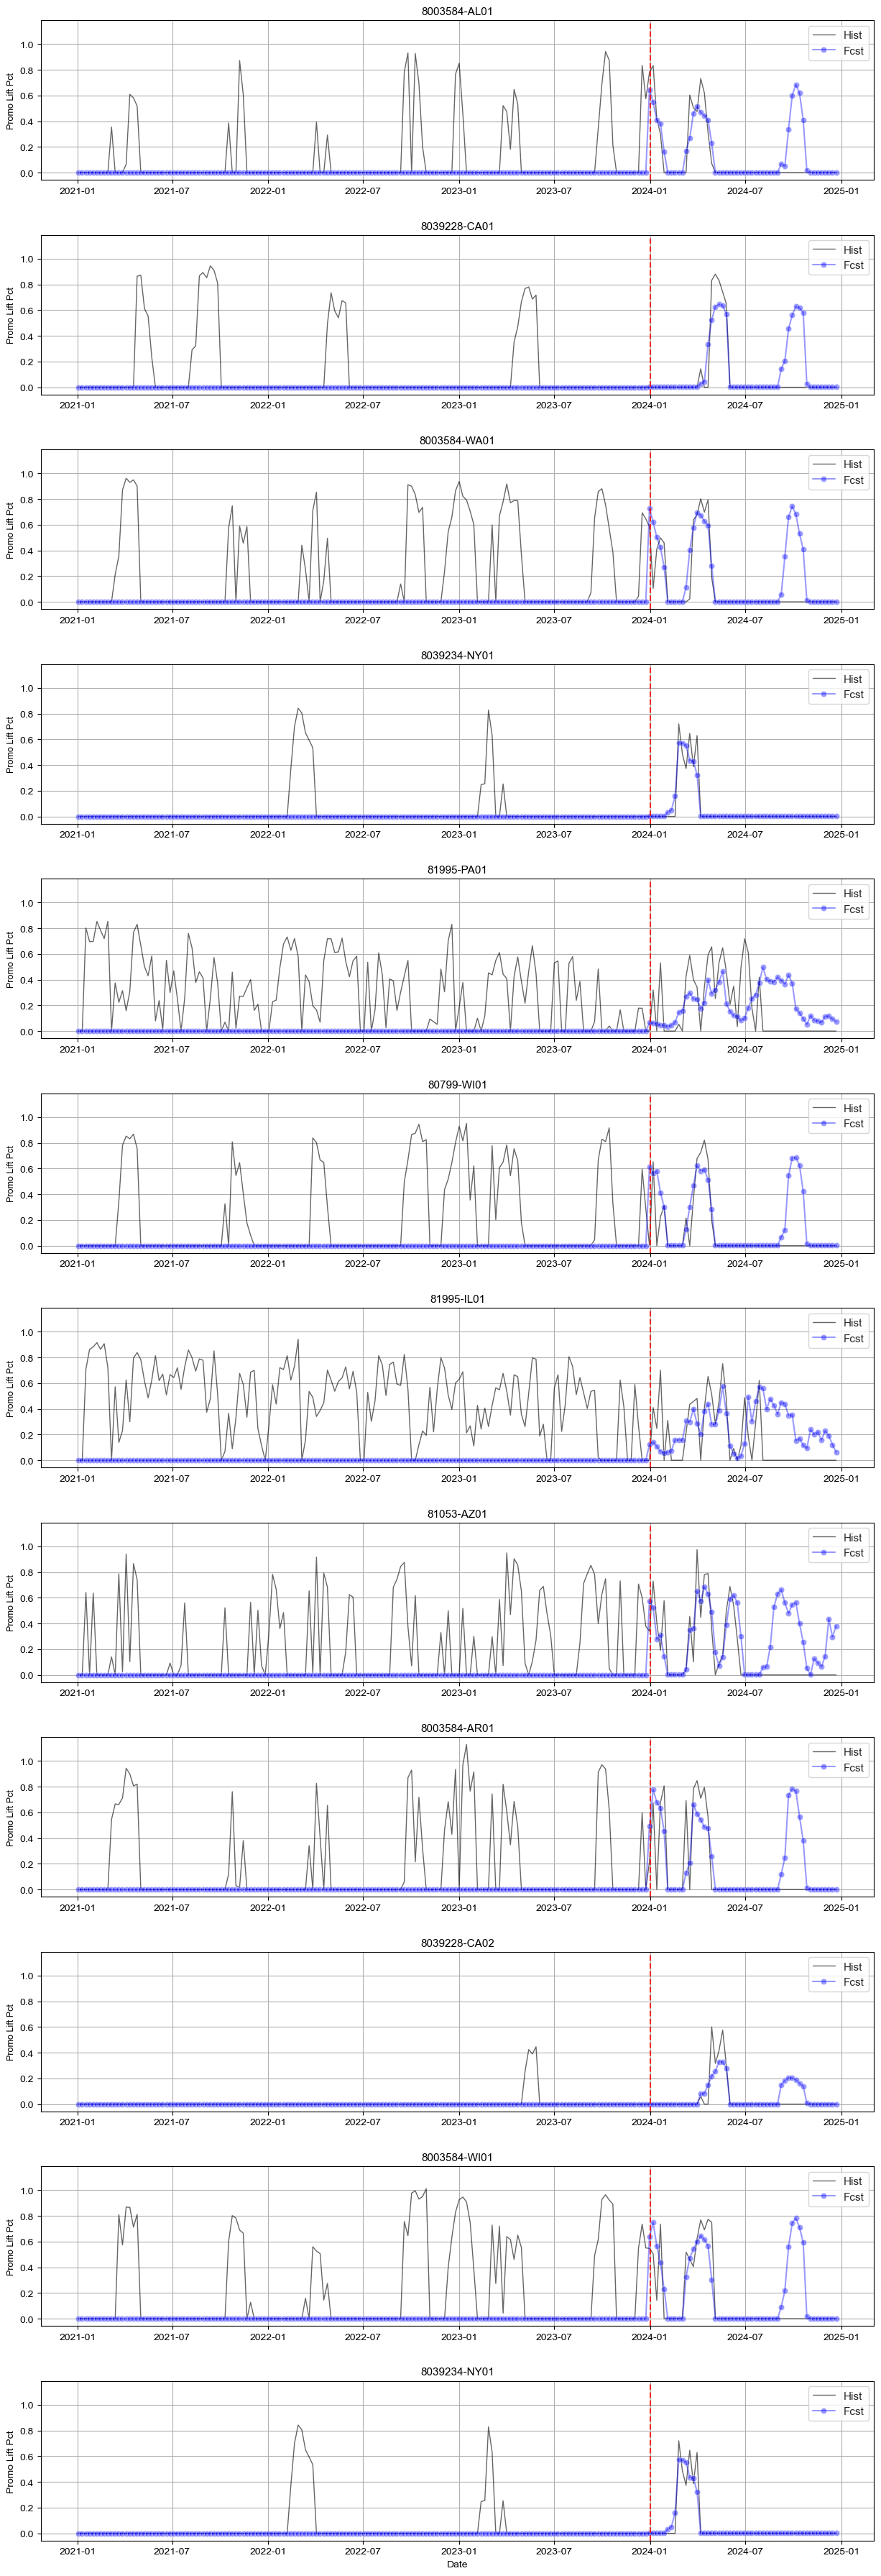

In [20]:
unique_ids_to_plot = [
    '8003584-AL01', 
    '8039228-CA01',
    '8003584-WA01',
    '8039234-NY01',
    '81995-PA01',
    '80799-WI01',
    '81995-IL01',
    '81053-AZ01',
    '8003584-AR01', 
    '8039228-CA02',
    '8003584-WI01',
    '8039234-NY01'
]
n = len(unique_ids_to_plot) # to make number of subplots dynamic per what is provided for ids to plot
fcst_start = pd.Timestamp('2024-01-01') # for vertical line on chart
# Set Seaborn style and color palette
fig, axes = plt.subplots(n, 1, figsize=(12.5, 3*n), sharey=True)
sns.set(style="whitegrid")  # can also use "darkgrid", "ticks", etc.
sns.set_palette("dark")  # can use other palettes like "deep", "muted", "dark", etc.
axes = axes.flatten()

for i, unique_id in enumerate(unique_ids_to_plot):
    vizdf = df_finaloutput[df_finaloutput['unique_id'] == unique_id]
    sns.lineplot(data=vizdf, x='ds', y='HIST', linewidth=1.0, color='black', alpha=0.60, label='Hist', ax=axes[i])
    sns.lineplot(data=vizdf, x='ds', y='FCST', linewidth=1.5, marker='o', color='blue', alpha=0.40,label='Fcst', ax=axes[i])
    axes[i].set_title(f'{unique_id}', fontsize=11)
    axes[i].set_xlabel(' ', fontsize=9)
    axes[i].set_ylabel('Promo Lift Pct', fontsize=9)
    axes[i].grid(True)
    axes[i].axvline(x=fcst_start, color='red', linestyle='--', linewidth=1.5,  alpha=0.80)
    axes[i].legend(loc='upper right')
   # axes[i].get_legend().remove() # to hide legend

# Customize the plot
#plt.suptitle('*** Example of Type 2 Promo Lift Pct Forecast - *** Target Variable ***', fontsize=14)
#plt.title('Model trained on data 2021-2023 to predict 2024 for next 52 weeks')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Promo Lift Pct', fontsize=10)
#plt.xticks(rotation=45)  # Rotate x-axis labels
#plt.grid(True)

# Show the plot
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()

### Feature Importance
* Specify top X number of features to include on data visualization

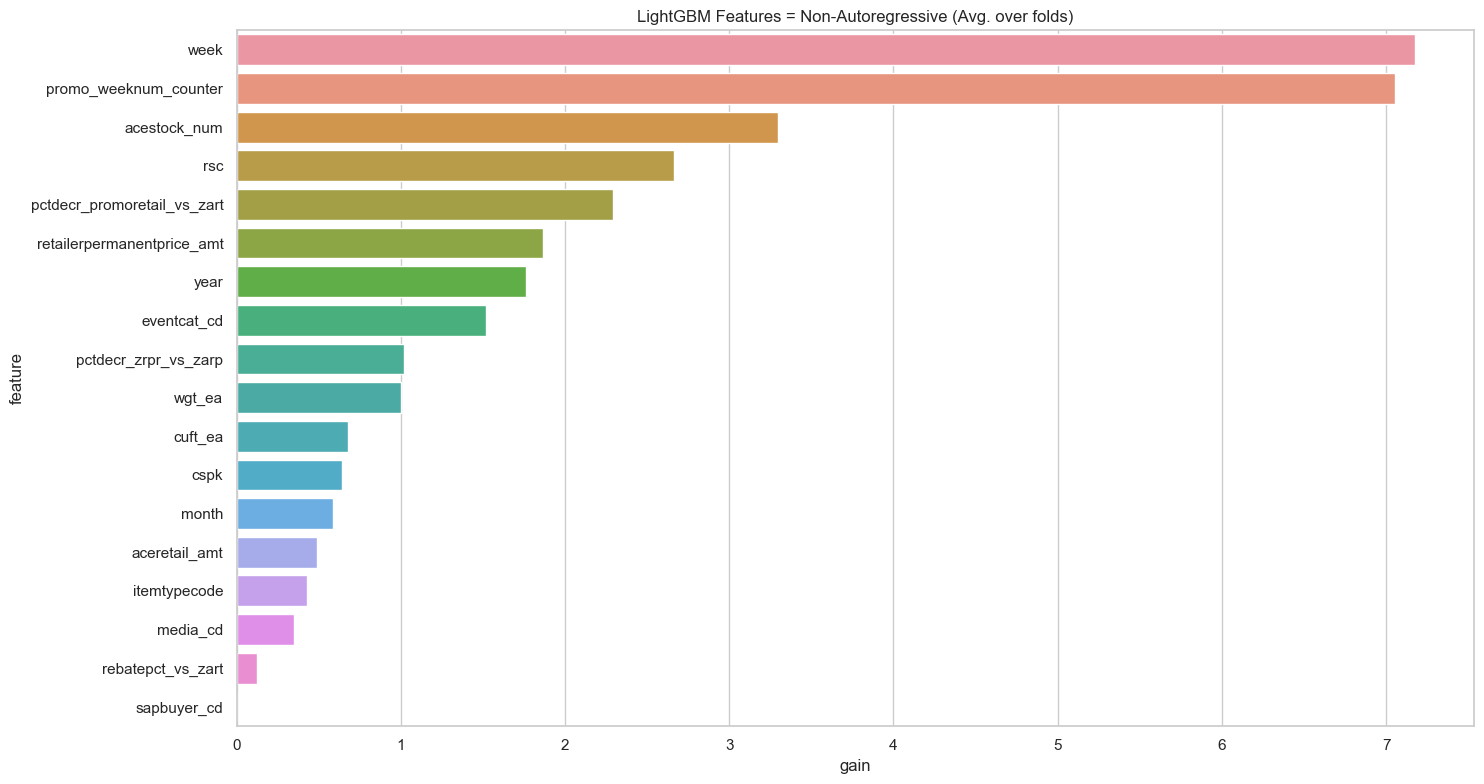

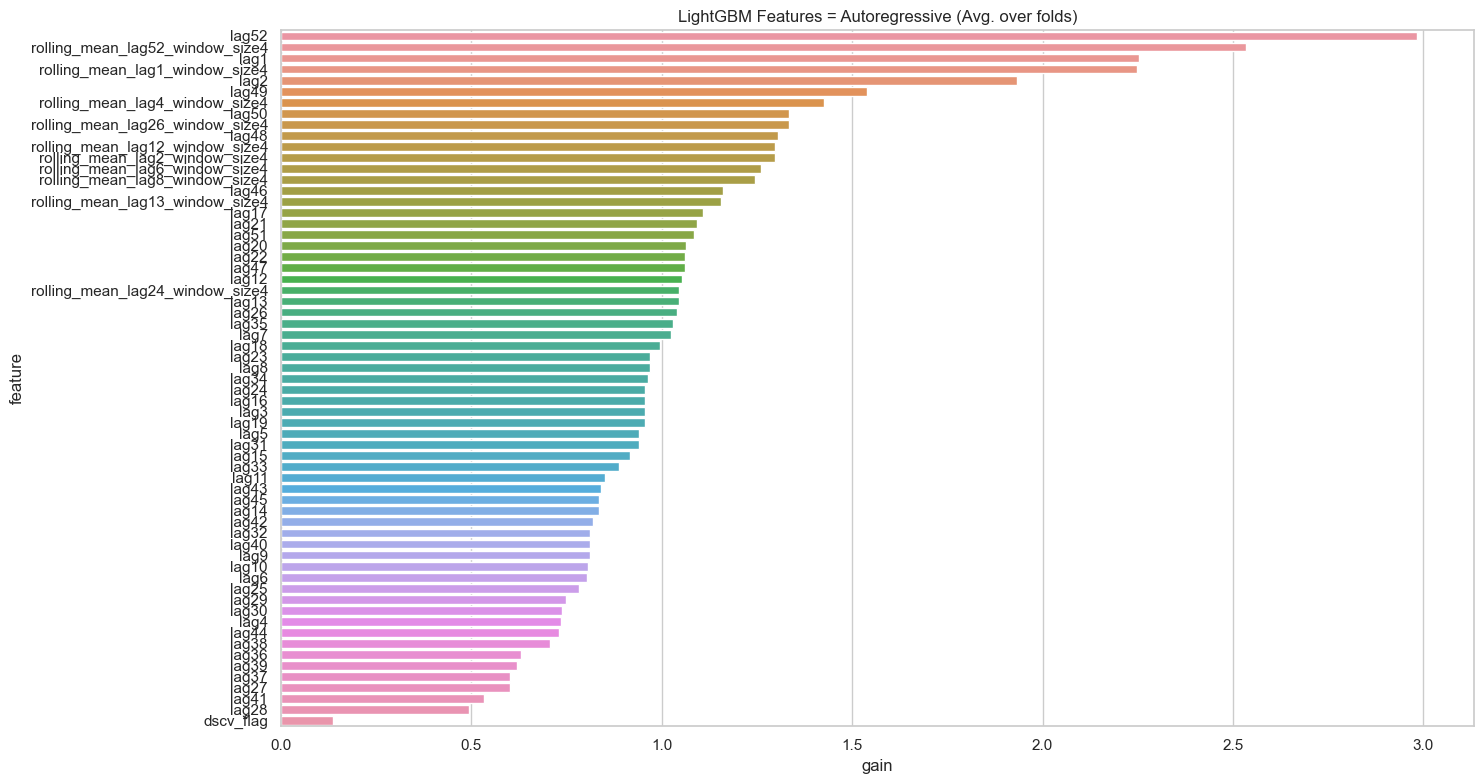

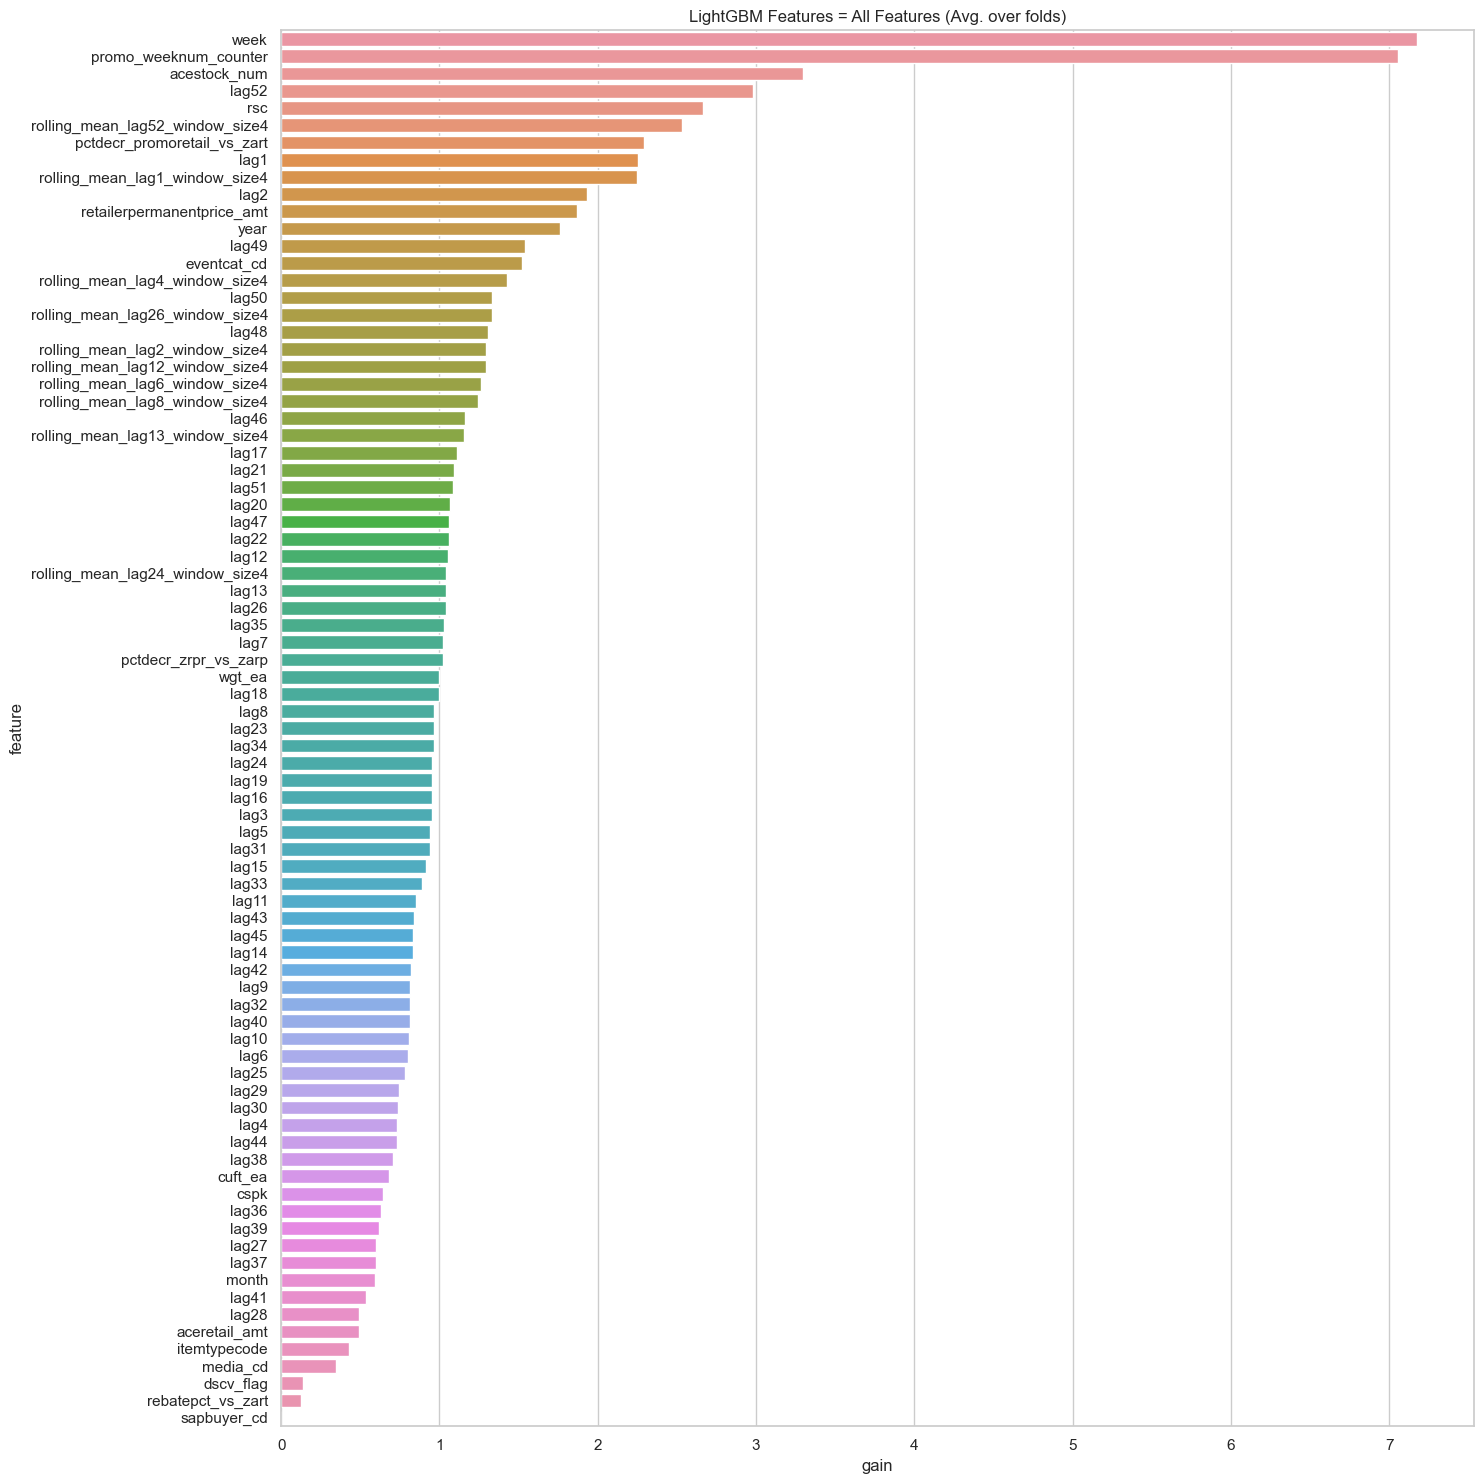

In [21]:
featimporance_display_top = 80
feat = get_feat_imp(fcst,featimporance_display_top)

feat_nonautoreg = feat[~feat['feature'].str.contains('lag', na=False)]
feat_autoreg = feat[feat['feature'].str.contains('lag', na=False)]

plt.figure(figsize=(15, 8))
sns.barplot(x="gain", y="feature", data=feat_nonautoreg.sort_values(by="gain", ascending=False))
plt.title('LightGBM Features = Non-Autoregressive (Avg. over folds)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 8))
sns.barplot(x="gain", y="feature", data=feat_autoreg.sort_values(by="gain", ascending=False))
plt.title('LightGBM Features = Autoregressive (Avg. over folds)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 15))
sns.barplot(x="gain", y="feature", data=feat.sort_values(by="gain", ascending=False))
plt.title('LightGBM Features = All Features (Avg. over folds)')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')

## Compute Accuracy Metrics
* Compute MAPE via AbsErr/Hist for 2024 Timeframe - Show as Accuracy Summary
* Compute Ace MAPE via Abs(SumFcst-SumHist)/SumHist - values via 4 WK totals

In [22]:
# Make Accuracy comparison detail table by DFU Week
# ONLY CONSIDER FORECAST WHERE HISTORICAL VALUES EXIST IN 2024

query = """
SELECT 
A.unique_id,
A.ds,
RANK() OVER (PARTITION BY A.unique_id order by A.ds ASC) AS weeknum,
B.y AS HIST,
A.y AS FCST,
ABS(COALESCE(B.y,0)-COALESCE(A.y,0)) AS abs_err
FROM final_fcst A 
INNER JOIN df_validate B
ON A.unique_id = B.unique_id AND A.ds=B.ds
WHERE A.DS<'2024-07-01'
"""
df_accuracy_detail = sqldf(query, globals())
df_accuracy_detail['ds'] = pd.to_datetime(df_finaloutput['ds']) 
df_accuracy_detail['y'] = np.maximum(df_finaloutput['FCST'] ,0)

# Make Summary of MAPE at Aggregate Level
query = """
SELECT 
COUNT(DISTINCT UNIQUE_ID) AS COUNT_DFUS,
SUM(HIST) AS TOTAL_HIST,
SUM(FCST) AS TOTAL_FCST,
SUM(abs_err) AS TOTAL_ABS_ERR,
SUM(abs_err) / SUM(HIST) AS MAPE
FROM df_accuracy_detail 
HAVING SUM(HIST)>0
"""
df_accuracy_summary = sqldf(query, globals())
print("\n" + 'Summarize Accuracy - MAPE (Standard Calculation per AbsErr by DFU by Week)' + "\n")
print(df_accuracy_summary)

# Make Summary of Ace MAPE at 4-Wk Increments
query = """

SELECT 
WEEK_CONSOLIDATE,
SUM(TOTAL_ABSERR) AS TOTAL_ABSERR,
SUM(TOTAL_HIST) AS TOTAL_HIST,
SUM(TOTAL_FCST) AS TOTAL_FCST,
SUM(TOTAL_ABSERR) / SUM(TOTAL_HIST) AS MAPE
FROM 
(SELECT
unique_id,
CASE WHEN weeknum between 1 AND 4 THEN 'WK_01_04'
WHEN weeknum between 5 AND 8 THEN 'WK_05_08'
WHEN weeknum between 9 AND 12 THEN 'WK_09_12'
WHEN weeknum between 13 AND 16 THEN 'WK_13_16'
WHEN weeknum between 17 AND 20 THEN 'WK_17_20'
WHEN weeknum between 21 AND 24 THEN 'WK_21_24'
WHEN weeknum between 25 AND 28 THEN 'WK_25_28'
WHEN weeknum between 29 AND 32 THEN 'WK_29_32'
ELSE NULL END AS WEEK_CONSOLIDATE,
SUM(HIST) AS TOTAL_HIST,
SUM(FCST) AS TOTAL_FCST,
ABS(SUM(FCST) - SUM(HIST)) AS TOTAL_ABSERR
FROM df_accuracy_detail 
GROUP BY 1,2 ) T1
GROUP BY 1 
"""
df_accuracy_4wkagg = sqldf(query, globals())

print("\n" + 'Summarize Accuracy in 4 Week Increments' + "\n")
print(df_accuracy_4wkagg)


# Aggregate Ace MAPE at 4-Wk Increments - Ace MAPE
query = """

SELECT
SUM(TOTAL_ABSERR) AS TOTAL_ABS_ERR,
SUM(TOTAL_HIST) AS TOTAL_HIST,
SUM(TOTAL_FCST) AS TOTAL_FCST,
CASE WHEN SUM(TOTAL_HIST) = 0 THEN 9.99 ELSE
SUM(TOTAL_ABSERR) / SUM(TOTAL_HIST) END AS MAPE
FROM
(SELECT 
WEEK_CONSOLIDATE,
COUNT(DISTINCT UNIQUE_ID) AS COUNT_DFUS,
SUM(TOTAL_ABSERR) AS TOTAL_ABSERR,
SUM(TOTAL_HIST) AS TOTAL_HIST,
SUM(TOTAL_FCST) AS TOTAL_FCST,
SUM(TOTAL_ABSERR) / SUM(TOTAL_HIST) AS MAPE
FROM 
(SELECT
unique_id,
CASE WHEN weeknum between 1 AND 4 THEN 'WK_01_04'
WHEN weeknum between 5 AND 8 THEN 'WK_05_08'
WHEN weeknum between 9 AND 12 THEN 'WK_09_12'
WHEN weeknum between 13 AND 16 THEN 'WK_13_16'
WHEN weeknum between 17 AND 20 THEN 'WK_17_20'
WHEN weeknum between 21 AND 24 THEN 'WK_21_24'
WHEN weeknum between 25 AND 28 THEN 'WK_25_28'
WHEN weeknum between 29 AND 32 THEN 'WK_29_32'
ELSE NULL END AS WEEK_CONSOLIDATE,
SUM(HIST) AS TOTAL_HIST,
SUM(FCST) AS TOTAL_FCST,
ABS(SUM(FCST) - SUM(HIST)) AS TOTAL_ABSERR
FROM df_accuracy_detail 
GROUP BY 1,2 ) T1
GROUP BY 1) T2
"""
df_accuracy_sum4wkagg = sqldf(query, globals())

print("\n" + 'Summarize 4 Week Increments Ace MAPE - In Total' + "\n")
print(df_accuracy_sum4wkagg)

# Make Summary of Ace MAPE at 8-Wk Increments
query = """

SELECT 
WEEK_CONSOLIDATE,
SUM(TOTAL_ABSERR) AS TOTAL_ABSERR,
SUM(TOTAL_HIST) AS TOTAL_HIST,
SUM(TOTAL_FCST) AS TOTAL_FCST,
SUM(TOTAL_ABSERR) / SUM(TOTAL_HIST) AS MAPE
FROM 
(SELECT
unique_id,
CASE WHEN weeknum between 1 AND 8 THEN 'WK_01_08'
WHEN weeknum between 9 AND 16 THEN 'WK_09_16'
WHEN weeknum between 17 AND 24 THEN 'WK_17_24'
WHEN weeknum between 25 AND 32 THEN 'WK_25_32'
ELSE NULL END AS WEEK_CONSOLIDATE,
SUM(HIST) AS TOTAL_HIST,
SUM(FCST) AS TOTAL_FCST,
ABS(SUM(FCST) - SUM(HIST)) AS TOTAL_ABSERR
FROM df_accuracy_detail 
GROUP BY 1,2 ) T1
GROUP BY 1 
"""
df_accuracy_8wkagg = sqldf(query, globals())

print ("\n" + 'Summarize Accuracy in 8 Week Increments' + "\n")
print(df_accuracy_8wkagg)


# Aggregate Ace MAPE at 8-Wk Increments - Ace MAPE
query = """

SELECT
CAST(SUM(TOTAL_ABSERR) AS DECIMAL(20,3)) AS TOTAL_ABS_ERR,
SUM(TOTAL_HIST) AS TOTAL_HIST,
SUM(TOTAL_FCST) AS TOTAL_FCST,
CASE WHEN SUM(TOTAL_HIST) = 0 THEN 9.99 ELSE
SUM(TOTAL_ABSERR) / SUM(TOTAL_HIST) END AS MAPE
FROM
(SELECT 
WEEK_CONSOLIDATE,
COUNT(DISTINCT UNIQUE_ID) AS COUNT_DFUS,
SUM(TOTAL_ABSERR) AS TOTAL_ABSERR,
SUM(TOTAL_HIST) AS TOTAL_HIST,
SUM(TOTAL_FCST) AS TOTAL_FCST,
SUM(TOTAL_ABSERR) / SUM(TOTAL_HIST) AS MAPE
FROM 
(SELECT
unique_id,
CASE WHEN weeknum between 1 AND 8 THEN 'WK_01_08'
WHEN weeknum between 9 AND 16 THEN 'WK_09_16'
WHEN weeknum between 17 AND 24 THEN 'WK_17_24'
WHEN weeknum between 25 AND 32 THEN 'WK_25_32'
ELSE NULL END AS WEEK_CONSOLIDATE,
SUM(HIST) AS TOTAL_HIST,
SUM(FCST) AS TOTAL_FCST,
ABS(SUM(FCST) - SUM(HIST)) AS TOTAL_ABSERR
FROM df_accuracy_detail 
GROUP BY 1,2) T1
GROUP BY 1) T2
"""
df_accuracy_sum8wkagg = sqldf(query, globals())

print("\n" + 'Summarize 8 Week Increments Ace MAPE - In Total' + "\n")
print(df_accuracy_sum8wkagg)


Summarize Accuracy - MAPE (Standard Calculation per AbsErr by DFU by Week)

   COUNT_DFUS  TOTAL_HIST   TOTAL_FCST  TOTAL_ABS_ERR      MAPE
0         722  2382.08518  2473.433833    1407.994461  0.591076

Summarize Accuracy in 4 Week Increments

  WEEK_CONSOLIDATE  TOTAL_ABSERR  TOTAL_HIST  TOTAL_FCST      MAPE
0         WK_01_04    139.855695  317.060873  318.453077  0.441100
1         WK_05_08    117.825876  189.528115  152.256352  0.621680
2         WK_09_12    130.066461  311.351968  318.535383  0.417747
3         WK_13_16    162.604208  431.295271  417.791528  0.377014
4         WK_17_20    212.730661  506.673353  582.324012  0.419858
5         WK_21_24    194.602376  390.476500  460.792588  0.498372
6         WK_25_28     91.954289  235.699100  223.280893  0.390134

Summarize 4 Week Increments Ace MAPE - In Total

   TOTAL_ABS_ERR  TOTAL_HIST   TOTAL_FCST      MAPE
0    1049.639566  2382.08518  2473.433833  0.440639

Summarize Accuracy in 8 Week Increments

  WEEK_CONSOLIDATE  T

## Next Steps
* NOW UPDATED 8/12/24 = Further feature engineering / pricing & promotional attributes / review features being used currently
* Holiday week one-hot encode - use SQL provided to Nousot for example of how to isolate those holidays (Check if there's a library we can grab these from instead)
* Consider if SHAP values would be useful & evaluate how to include.

Probable considerations after this:
* Consider if prediction intervals would be useful & evalute how to include
* Consider custom loss function to bias to overforecasting vs. underforecasting
* Cross validation and hyperparam tuning
* See documentation and how-to guides available here: https://nixtlaverse.nixtla.io/mlforecast/forecast.html


In [23]:
#prep.to_csv("C:\\Users\\nlarm\\OneDrive - Ace Hardware CORP\\Documents\\Python Data Files\\PROMO_LIFT_POC.csv", index=False)